# <span style='color:royalblue'> <u> The Effect of Feedback on Driver Behaviour </u> </span>
>#### <span style='color:midnightblue'> Author: Greg Carrigan </span>
#### <span style='color:midnightblue'> Thanks to Ian Davidson of GoFar for providing the data </span>

##### <span style='color:darkgreen'> <u>Notebook 1 of 2:</u> Aim, data cleansing and initial exploratory analysis. </span>

##### <span style='color:darkgreen'> Notebook 2 can be found here: </span>
https://git.generalassemb.ly/DSI-SYD-2/capstone_greg/blob/master/part-04/capstone_greg_analysis_discussion.ipynb

###  <span style='color:royalblue'> <u>Aim / Problem Statement:</u></span>

 <span style='color:midnightblue'> GoFar is a local Sydney company who have developed an adapter, or "Connector", that plugs into your car console under the dashboard and collects information as you drive. From the GoCar web site: </span>

><span style='color:navy'> <b><i>"It captures your car’s health and driving data and using the information it finds ways to save you time, money or just make your life easier."</i></b></span>

<span style='color:midnightblue'> There is an app that you can download to your smartphone that allows you to access all the data that is collected. However, it is the third piece to the puzzle, known as the "Ray", that opens up possibilities for analysis. </span>

 <span style='color:midnightblue'> The Ray is essentially another adapter that plugs into the connector and sits on the dashboard, where the driver can see it. It has a row of lights that glows blue or red to give you feedback on how you are driving. From the web site again: </span>

><span style='color:navy'> <b><i>"Every engine speed has a sweet spot - an optimum position that maximises your power and minimises your fuel consumption. It's where your car runs best and uses the least fuel."</i></b> </span>

<span style='color:midnightblue'> The Ray glows blue when it determines that you are driving in this sweet spot, and changes to red when you are not. However, drivers don't always connect the Ray. This means that data is available for both when the Ray is connected and when it is not, i.e. for when the driver is receiving feedback, and when they are not. </span>

 <span style='color:midnightblue'> The aim of this project is to analyse data from connectors to determine whether there is any statistical difference in driving behaviour when the Ray is on compared to when it is off. The primary emphasis will be on examining whether fuel consumption is reduced, and what variables are most influential in determining fuel consumption. Other variables such as braking activity, speed and sidewise movement will also be examined to see whether they vary significantly. </span>

###  <span style='color:royalblue'> <u>Proposed Methods and Models</u> </span>

 <span style='color:midnightblue'> The data is provided in .csv files, one for each driver. Both individual and overall behaviour will be analysed. Statistical analysis will be employed to estimate whether any differences observed are significant. Other methods such as multiple linear regression will be used to see what measures of driving behaviour, if any, are a good indicator of whether the Ray is turned on or off. </span>

<span style='color:midnightblue'> Some research will also be done into imputing missing data. </span>

### <span style='color:royalblue'> <u> Risks and Assumptions</u> </span>

<span style='color:midnightblue'> There are two main assumptions with the data: </span>

>#### <span style='color:midnightblue'>1. That the subset of drivers for whom data is available are representative of all drivers who could use the connector and Ray. </span>
#### <span style='color:midnightblue'>2. That the data available for each individual driver is representative of that driver's behaviour. </span> 

 <span style='color:midnightblue'> There is a risk that any effects of driver behaviour will be overshadowed by the effect of other variables. </span>


###  <span style='color:royalblue'> <u>Importing Data and Storage Creation - panda DataFrame </u></span>


In [2]:
import numpy as np
import pandas as pd
import sqlite3
from pandas.io import sql
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### <span style='color:midnightblue'> The data is read in from 24 .csv files, one for each driver. A driver_id column is added. </span>

In [11]:
#file_path = 'C:/Users/gregc_000/Documents/GitHub/capstone_greg/GOFAR Data/'
file_path = '../GOFAR Data/'

drive = pd.DataFrame()
for i in range(1,25):
    csv_file = file_path + 'Driver'+str(i)+'.csv'
    file = pd.read_csv(csv_file)
    file['driver_id'] = str(i)
    drive = pd.concat([drive, file], axis=0)

###  <span style='color:royalblue'> <u>Query, Sort and Clean Data</u></span>
#### <span style='color:midnightblue'> First I will take a high level look at the data. </span>

In [3]:
print ("Data shape: \n", drive.shape)
print ()
print ("Data columns, data type and number of null values:")
print ()
print (drive.info())
print ()
print ("Descriptive statistics:")
print ()
print (drive.describe())
print ()
print ("Data example: \n")
print (drive.head())

Data shape: 
 (975929, 14)

Data columns, data type and number of null values:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975929 entries, 0 to 2186
Data columns (total 14 columns):
speed                975929 non-null int64
rpm                  975929 non-null float64
distance             975929 non-null float64
liter                975929 non-null float64
xaxisacceleration    975929 non-null float64
yaxisacceleration    975929 non-null float64
zaxisgyroscope       975929 non-null float64
longitude            641728 non-null float64
latitude             641728 non-null float64
timestamp_utc        975929 non-null object
index                975929 non-null int64
tripid               975929 non-null object
raynotconnected      975929 non-null bool
driver_id            975929 non-null object
dtypes: bool(1), float64(8), int64(2), object(3)
memory usage: 105.2+ MB
None

Descriptive statistics:

               speed           rpm       distance          liter  \
count  975929.00000

#### <span style='color:midnightblue'> The data consists of values for speed (km/h), engine rpm, trip distance (km), forward acceleration, sideways acceleration, gyroscope (i.e. rocking), longitude and latitude, a timestamp, trip index, trip ID, whether the Ray is connected and a driver ID. </span>

#### <span style='color:midnightblue'> When reading in records from multiple files, the index can restart at 0. It needs to be checked and reset if this is the case. </span>

In [4]:
drive.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186],
           dtype='int64', length=975929)

#### <span style='color:midnightblue'>  The last index number does not match the total number of records, so it will be reset. </span>

In [12]:
drive.reset_index(drop=True, inplace=True)
print (drive.index)
drive.tail(1)

RangeIndex(start=0, stop=975929, step=1)


,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,index,tripid,raynotconnected,driver_id
975928,0,752.0,3.09,0.26,0.03,-0.03,0.72,-3.16,51.48,2017-04-06 06:42:33+00,257,0c88c989-5803-3c99-2ed3-fb254d9503cd,True,24


#### <span style='color:midnightblue'> I'll go through the data, looking for anything that appears incorrect or outliers that could be removed. </span>

#### <span style='color:midnightblue'> First, I'd like to check whether there are any trips that overlap by seeing whether the trip IDs are continuous. </span>

In [13]:
for i in range(1, len(drive)-1):
    if drive.loc[i, 'tripid'] != drive.loc[i-1, 'tripid']:
        if drive.loc[i, 'tripid'] != drive.loc[i+1, 'tripid']:
            print (i)

626235
626236
626239
626240
626243
626244
974510
974511
974512
974513
974514
974515
974516
974519
974520
974523


#### <span style='color:midnightblue'> It looks like there are a couple. I'll take a look at the records. </span>

In [14]:
drive.tripid[626235:626244]

626235    f75495fd-ccc6-91d7-0f46-bc01444cf7f5
626236    bbbf254a-3855-8c45-2421-b45a962b8e76
626237    f75495fd-ccc6-91d7-0f46-bc01444cf7f5
626238    f75495fd-ccc6-91d7-0f46-bc01444cf7f5
626239    bbbf254a-3855-8c45-2421-b45a962b8e76
626240    f75495fd-ccc6-91d7-0f46-bc01444cf7f5
626241    bbbf254a-3855-8c45-2421-b45a962b8e76
626242    bbbf254a-3855-8c45-2421-b45a962b8e76
626243    f75495fd-ccc6-91d7-0f46-bc01444cf7f5
Name: tripid, dtype: object

In [15]:
ess_cols = ['speed', 'liter', 'distance', 'timestamp_utc', 'index', 'driver_id']

In [16]:
drive[ess_cols][drive.tripid == 'bbbf254a-3855-8c45-2421-b45a962b8e76']

,speed,liter,distance,timestamp_utc,index,driver_id
626231,0,1.83,27.46,2017-04-19 19:34:15+00,797,14
626232,0,1.83,27.46,2017-04-19 19:34:18+00,798,14
626233,0,1.83,27.46,2017-04-19 19:34:21+00,799,14
626234,0,1.83,27.46,2017-04-19 19:34:23+00,800,14
626236,0,1.83,27.46,2017-04-19 19:34:25+00,801,14
626239,0,1.83,27.46,2017-04-19 19:34:28+00,802,14
626241,0,1.83,27.46,2017-04-19 19:34:30+00,803,14
626242,0,1.83,27.46,2017-04-19 19:34:32+00,804,14
626244,0,1.83,27.46,2017-04-19 19:34:35+00,805,14


In [17]:
    drive[ess_cols][drive.tripid == 'f75495fd-ccc6-91d7-0f46-bc01444cf7f5'].head(10)

,speed,liter,distance,timestamp_utc,index,driver_id
626235,0,0.00,0.0,2017-04-19 19:34:23+00,0,14
626237,0,0.00,0.0,2017-04-19 19:34:25+00,1,14
626238,0,0.00,0.0,2017-04-19 19:34:28+00,2,14
626240,0,0.00,0.0,2017-04-19 19:34:30+00,3,14
626243,0,0.00,0.0,2017-04-19 19:34:32+00,4,14
626245,0,0.00,0.0,2017-04-19 19:34:35+00,5,14
626246,0,0.00,0.0,2017-04-19 19:34:37+00,6,14
626247,0,0.00,0.0,2017-04-19 19:34:39+00,7,14
626248,0,0.00,0.0,2017-04-19 19:34:42+00,8,14
626249,0,0.01,0.0,2017-04-19 19:34:44+00,9,14


#### <span style='color:midnightblue'> There is an overlap in the timestamps for the two trips, which should not be possible. The first trip, with ID 'bbbf254a-3855-8c45-2421-b45a962b8e76', only has nine records, starting from trip index 797, so it will be deleted. </snap>

In [18]:
drive = drive[drive.tripid != 'bbbf254a-3855-8c45-2421-b45a962b8e76']

#### <span style='color:midnightblue'> Now for the second lot of overlapping records </span>

In [19]:
drive.tripid[974510:974523]

974519    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974520    cf6827ab-1000-5282-5bfd-544ce177edba
974521    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974522    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974523    cf6827ab-1000-5282-5bfd-544ce177edba
974524    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974525    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974526    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974527    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974528    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974529    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974530    a1a1870c-dff2-a791-0cf0-ef67bf07305f
974531    a1a1870c-dff2-a791-0cf0-ef67bf07305f
Name: tripid, dtype: object

In [20]:
drive[ess_cols][drive.tripid == 'cf6827ab-1000-5282-5bfd-544ce177edba']

,speed,liter,distance,timestamp_utc,index,driver_id
974492,41,0.12,1.25,2017-03-26 12:47:32+00,142,24
974493,35,0.12,1.27,2017-03-26 12:47:34+00,143,24
974494,32,0.12,1.30,2017-03-26 12:47:37+00,144,24
974495,38,0.12,1.33,2017-03-26 12:47:40+00,145,24
974496,36,0.12,1.36,2017-03-26 12:47:43+00,146,24
974497,34,0.12,1.38,2017-03-26 12:47:45+00,147,24
974498,23,0.12,1.40,2017-03-26 12:47:48+00,148,24
974499,30,0.13,1.42,2017-03-26 12:47:50+00,149,24
974500,29,0.13,1.44,2017-03-26 12:47:53+00,150,24
974501,28,0.13,1.46,2017-03-26 12:47:55+00,151,24


In [21]:
drive[ess_cols][drive.tripid == 'a1a1870c-dff2-a791-0cf0-ef67bf07305f'].head(10)

,speed,liter,distance,timestamp_utc,index,driver_id
974510,22,0.00,0.00,2017-03-26 12:48:14+00,0,24
974512,9,0.00,0.01,2017-03-26 12:48:17+00,1,24
974514,14,0.00,0.02,2017-03-26 12:48:19+00,2,24
974516,13,0.00,0.03,2017-03-26 12:48:21+00,3,24
974519,19,0.00,0.04,2017-03-26 12:48:24+00,4,24
974521,15,0.00,0.05,2017-03-26 12:48:26+00,5,24
974522,20,0.01,0.06,2017-03-26 12:48:28+00,6,24
974524,26,0.01,0.08,2017-03-26 12:48:30+00,7,24
974525,27,0.01,0.10,2017-03-26 12:48:33+00,8,24
974526,24,0.01,0.11,2017-03-26 12:48:35+00,9,24


#### <span style='color:midnightblue'> This situation is even stranger. At least in the first case, the car wasn't moving. In this case, it is recording two different speeds at the same time, and the second trip starts at a speed of 22 km/hr! I will delete the first trip, which starts at a trip index of 142. The second trip looks OK, except for that starting speed. I will set it to zero. </span>

In [22]:
drive = drive[drive.tripid != 'cf6827ab-1000-5282-5bfd-544ce177edba']
drive.loc[974510, 'speed'] = 0

#### <span style='color:midnightblue'> Now the index will need to be reset again. </span>

In [23]:
drive.reset_index(drop=True, inplace=True)

#### <span style='color:midnightblue'> Having a column named 'index' could cause confusion, so I will rename it to 'trip_index'. </span>

In [24]:
drive.rename(columns={'index':'trip_index'}, inplace=True)

#### <span style='color:midnightblue'> The column 'raynotconnected' may also cause confusion, as True will mean it is not connected, and False will be a double negative, meaning it is connected. I will change the colum name to 'ray_connected' and change the values to 0 for True and 1 for False. </span>

In [25]:
print (drive.raynotconnected.value_counts())
drive.rename(columns={'raynotconnected':'ray_connected'}, inplace=True)
drive.ray_connected = drive.ray_connected.map(lambda x: 0 if x == True else 1)
print (drive.ray_connected.value_counts())

True     571840
False    404055
Name: raynotconnected, dtype: int64
0    571840
1    404055
Name: ray_connected, dtype: int64


#### <span style='color:midnightblue'> The maximum speed of 255 looks incorrect. I will take a look at these records. </span>

In [26]:
print ("{:50}".format("The number of records with speed = 255 is:  "), (drive.speed[drive.speed == 255].count()))
print ("{:50}".format("The drivers with these records are:  "), drive.driver_id[drive.speed == 255].unique())

The number of records with speed = 255 is:         1030
The drivers with these records are:                ['1' '9' '14']


In [27]:
print ("Driver 1's records:")
drive[(drive.speed == 255) & (drive.driver_id == '1')]

Driver 1's records:


,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id
51015,255,793.75,0.0,0.0,0.03,-0.04,-2.35,-2.69,51.5,2017-03-23 19:46:44+00,3,f0613205-0c04-900f-b4dc-83d17f15f1eb,0,1


#### <span style='color:midnightblue'> I will look at the records just above and below this record. </span>


In [28]:
drive[(drive.tripid == 'f0613205-0c04-900f-b4dc-83d17f15f1eb') & (drive.trip_index < 5)]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id
51012,0,720.75,0.00,0.0,0.07,-0.05,-2.65,NaN,NaN,2017-03-23 19:46:39+00,0,f0613205-0c04-900f-b4dc-83d17f15f1eb,0,1
51013,0,770.25,0.00,0.0,0.03,-0.04,-22.83,-2.69,51.5,2017-03-23 19:46:40+00,1,f0613205-0c04-900f-b4dc-83d17f15f1eb,0,1
51014,0,805.75,0.00,0.0,0.03,-0.04,-2.39,-2.69,51.5,2017-03-23 19:46:42+00,2,f0613205-0c04-900f-b4dc-83d17f15f1eb,0,1
51015,255,793.75,0.00,0.0,0.03,-0.04,-2.35,-2.69,51.5,2017-03-23 19:46:44+00,3,f0613205-0c04-900f-b4dc-83d17f15f1eb,0,1
51016,0,946.25,0.02,0.0,0.04,-0.04,-2.35,-2.69,51.5,2017-03-23 19:46:46+00,4,f0613205-0c04-900f-b4dc-83d17f15f1eb,0,1


#### <span style='color:midnightblue'> The speed for this record should clearly be 0. </span>

In [29]:
drive.loc[51015,'speed'] = 0

#### <span style='color:midnightblue'> Now look at driver 9. </span>

In [30]:
drive[(drive.speed == 255) & (drive.driver_id == '9')]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id
340466,255,112.50,0.0,0.0,0.01,-0.02,4.48,NaN,NaN,2017-03-25 08:55:53+00,0,a7d46426-4ea9-3a22-6a81-80ea1436e453,0,9
344254,255,982.75,0.0,0.0,-0.04,-0.04,5.45,NaN,NaN,2017-03-28 07:42:12+00,0,f4101722-41df-8bc6-2dd1-24a2a3a71a1e,0,9
349403,255,829.00,0.0,0.0,-0.02,-0.05,5.54,NaN,NaN,2017-03-31 07:44:24+00,0,75e60ed3-b8c1-1308-13ae-418099ae68e2,0,9
353227,255,850.25,0.0,0.0,-0.03,-0.03,4.90,NaN,NaN,2017-04-01 08:30:10+00,0,a3138532-cf64-5644-e587-697fae8bfbc2,0,9
358299,255,791.75,0.0,0.0,-0.02,-0.05,5.08,NaN,NaN,2017-04-06 07:44:58+00,0,1b116bf2-cd3c-7a71-39bc-2bbd726a376e,0,9
361202,255,791.75,0.0,0.0,-0.02,-0.02,4.83,NaN,NaN,2017-04-09 09:18:38+00,0,47c8dd7e-3095-80f1-de5f-b1bf13681730,0,9
361544,255,770.25,0.0,0.0,0.02,-0.10,4.58,NaN,NaN,2017-04-10 07:48:04+00,0,1c74aa9e-0277-aac4-7c61-ed7d59b2e28e,0,9
363035,255,781.75,0.0,0.0,-0.03,-0.04,4.75,NaN,NaN,2017-04-11 08:03:53+00,0,f9482e82-c21f-8441-442e-ee5b76642207,0,9


#### <span style='color:midnightblue'> The trip index and distance are 0 for each of these records, i.e. they are the first record of the trip and so the speed should be 0. </span>

In [31]:
dr9_255_index = drive[(drive.speed == 255) & (drive.driver_id == '9')].index

for i in dr9_255_index:
    drive.loc[i,'speed'] = 0

#### <span style='color:midnightblue'> There are about 1000 records with speed = 255 left, all for driver 14. I will check to see whether they are at the start of a trip. </span>

In [36]:
dr14_255 = drive[(drive.speed == 255) & (drive.driver_id == '14')]
print ("The number of unique trips that include a speed of 255 is:", "{:>5}".format(dr14_255.tripid.nunique()))
print ()
dr14_255.describe()

The number of unique trips that include a speed of 255 is:    97



,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,trip_index,ray_connected
count,1021.0,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,473.000000,473.000000,1021.000000,1021.000000
mean,255.0,81.631978,19.676523,1.412380,-0.004574,-0.005152,0.737385,-3.263319,51.454440,863.048972,0.426053
std,0.0,220.685100,13.314394,0.947865,0.034262,0.040527,0.456989,0.106039,0.045535,551.089580,0.494744
min,255.0,0.000000,0.030000,0.030000,-0.320000,-0.120000,-0.550000,-3.420000,51.400000,50.000000,0.000000
25%,255.0,0.000000,6.180000,0.470000,-0.020000,-0.030000,0.520000,-3.420000,51.400000,366.000000,0.000000
50%,255.0,0.000000,23.600000,1.520000,-0.010000,-0.010000,0.640000,-3.230000,51.480000,819.000000,0.000000
75%,255.0,0.000000,31.690000,2.340000,0.020000,0.020000,0.880000,-3.170000,51.480000,1299.000000,1.000000
max,255.0,904.750000,40.730000,2.810000,0.110000,0.100000,12.280000,-3.170000,51.530000,2097.000000,1.000000


#### <span style='color:midnightblue'> The minimum trip_index is 50, so these records are not at the start. There are 97 trips that include a speed of 255, so there may be an issue with this device. I will take a look at the records above and below for one of the trips. </span>

In [38]:
dr14_255.tripid.value_counts().head().index[0:10]

Index(['8b21dd1b-2ae6-4e01-b343-aadcff811ef7',
       'e31f9c09-4fae-75ac-2807-e5c43e56f3ab',
       'c88d03f3-442c-1dc0-24de-bdaa41b85c5a',
       'd403b3e9-444f-6787-5fa7-122facf96f1c',
       '8196fbb6-50d1-afe5-21f6-6a3b6766fa80'],
      dtype='object')

In [39]:
dr14_255.trip_index[dr14_255.tripid == 'e31f9c09-4fae-75ac-2807-e5c43e56f3ab']

598445    442
598446    443
598447    444
598448    445
598449    446
598450    447
598451    448
598452    449
598453    450
598454    451
598877    874
598878    875
598879    876
598880    877
598881    878
598882    879
598883    880
598884    881
598885    882
598886    883
598887    884
Name: trip_index, dtype: int64

#### <span style='color:midnightblue'> The device malfunctions twice during this trip! I will take a look at each. </span>

In [40]:
ess_cols = ['speed', 'rpm', 'distance', 'xaxisacceleration', 'longitude',
            'latitude', 'timestamp_utc', 'trip_index']
for i in range (437,454):
    print (drive[ess_cols][(drive.tripid == 'e31f9c09-4fae-75ac-2807-e5c43e56f3ab') & (drive.trip_index == i)])
print ()
for j in range (869,889):
    print (drive[ess_cols][(drive.tripid == 'e31f9c09-4fae-75ac-2807-e5c43e56f3ab') & (drive.trip_index == j)])

        speed    rpm  distance  xaxisacceleration  longitude  latitude  \
598440      0  704.5     11.08              -0.03      -3.28      51.4   

                 timestamp_utc  trip_index  
598440  2017-03-31 15:43:09+00         437  
        speed     rpm  distance  xaxisacceleration  longitude  latitude  \
598441      0  691.75     11.08              -0.03      -3.28      51.4   

                 timestamp_utc  trip_index  
598441  2017-03-31 15:43:11+00         438  
        speed     rpm  distance  xaxisacceleration  longitude  latitude  \
598442      0  694.25     11.08              -0.03      -3.28      51.4   

                 timestamp_utc  trip_index  
598442  2017-03-31 15:43:13+00         439  
        speed    rpm  distance  xaxisacceleration  longitude  latitude  \
598443      0  688.0     11.08              -0.03      -3.28      51.4   

                 timestamp_utc  trip_index  
598443  2017-03-31 15:43:15+00         440  
        speed    rpm  distance  xaxisacc

#### <span style='color:midnightblue'> It seems as though the device has malfunctioned when the vehicle is stopped, recording 255 for the speed when it is 0. I will check the other records with a speed of 255 to see whether the record above and below is either 0 or 255. If so, they can all be set to 0. </span>

In [41]:
for i in dr14_255.index:
    if ((drive.loc[i-1].tripid == drive.loc[i].tripid) & (drive.loc[i-1].speed not in (0, 255))):
        print (drive.loc[i-1][ess_cols])
    if ((drive.loc[i+1].tripid == drive.loc[i].tripid) & (drive.loc[i+1].speed not in (0, 255))):
        print (drive.loc[i+1][ess_cols])

speed                                     3
rpm                                 1251.75
distance                               8.55
xaxisacceleration                     -0.17
longitude                             -3.23
latitude                              51.52
timestamp_utc        2017-04-13 17:05:44+00
trip_index                              369
Name: 626212, dtype: object


#### <span style='color:midnightblue'> There is only one record. I will take a look at a few records above and below. <span>

In [42]:
print (drive[ess_cols].loc[626208:626217])

        speed      rpm  distance  xaxisacceleration  longitude  latitude  \
626208    255     0.00      7.79               0.03      -3.23     51.52   
626209    255     0.00      7.96              -0.01      -3.23     51.52   
626210    255     0.00      8.10              -0.01      -3.23     51.52   
626211    255     0.00      8.28              -0.01      -3.23     51.52   
626212      3  1251.75      8.55              -0.17      -3.23     51.52   
626213      0  1042.75      8.55               0.00      -3.23     51.52   
626214      0   706.75      8.55              -0.16      -3.23     51.52   
626215      0   928.50      8.55               0.02      -3.23     51.52   
626216      1  1052.25      8.55               0.11      -3.23     51.52   
626217      5   942.00      8.55               0.13      -3.23     51.52   

                 timestamp_utc  trip_index  
626208  2017-04-13 17:03:22+00         363  
626209  2017-04-13 17:03:24+00         364  
626210  2017-04-13 17:03:26+

#### <span style='color:midnightblue'> These speeds also look like they should be 0. They will be reset. </span>

In [43]:
for i in dr14_255.index:
    drive.loc[i, 'speed'] = 0

#### <span style='color:midnightblue'> There is still a problem, however. The distance reading is calculated from the speed, so it is incorrect for all the records that were just changed for driver 14, and any subsequent records in the same trip. My solution to this problem is that I will create a new column for distance travelled, which I will calculate from the speed and timestamp. </span>

#### <span style='color:midnightblue'> The 'timestamp_utc' column is of type 'object'. This will be converted to datetime'. </span> 

In [44]:
drive['date_time'] = pd.to_datetime(drive['timestamp_utc'], format = '%Y-%m-%d %H:%M:%S')
drive['date_time'].head(2)

0   2017-03-08 06:33:31
1   2017-03-08 06:33:33
Name: date_time, dtype: datetime64[ns]

#### <span style='color:midnightblue'> Now a new column will be added to calculate the time difference between records in seconds. If the record is the first for a trip, the time will be set to zero. Note that I can't just rely on the trip index, since there are some missing records and not all trips start at one. </span>

#### <span style='color:midnightblue'> I will also check whether the speed and distance are both zero. If so, the time will again be set to zero. This is so that the trip is deemed to have started only when the car starts moving, and the time spent between turning the engine on and actually driving is discounted. This is so that fuel consumed before moving is not included.</span>

In [45]:
drive.loc[0, 'delta_time'] = 0
for i in range(1, len(drive)):
    if drive.tripid[i] != drive.tripid[i-1]:
        drive.loc[i, 'delta_time'] = 0
    elif ((drive.loc[i, 'distance'] == 0.0) & (drive.loc[i, 'speed'] == 0.0)):
        drive.loc[i, 'delta_time'] = 0
    else:
        drive.loc[i, 'delta_time'] = (drive.loc[i, 'date_time'] - drive.loc[i-1, 'date_time']).total_seconds()

In [4]:
drive.delta_time.describe()

count    975895.000000
mean          2.089903
std           5.286191
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max        2661.000000
Name: delta_time, dtype: float64

#### <span style='color:midnightblue'> Now a new calculated cumulative distance for the trip will be added to another column. I will only calculate this for driver_id 14, who had records with a speed of 255. For the other drivers, I'll just copy the existing distance record. The distance will be calculated by taking the average of the speed for each record and the preceding one (km/h), multiplying it by the time difference in seconds divided by 3600 to convert it to hours. This results in a distance in km. </span>

In [8]:
drive.loc[0, 'calc_dist'] = 0
for i in range(1, len(drive)):
    if drive.loc[i, 'driver_id'] != '14':
        drive.loc[i, 'calc_dist'] = drive.loc[i, 'distance']
    elif drive.loc[i, 'driver_id'] == '14':
        if drive.loc[i, 'tripid'] != drive.loc[i-1, 'tripid']:
            drive.loc[i, 'calc_dist'] = drive.loc[i, 'distance']
        else:
            drive.loc[i, 'calc_dist'] = (drive.loc[i, 'delta_time'] / 3600) * (((drive.loc[i-1, 'speed'])
        + (drive.loc[i, 'speed'])) / 2 ) + drive.loc[i-1, 'calc_dist']

In [9]:
print (drive[drive.driver_id == '14'].calc_dist.describe())
print ()
print (drive[drive.driver_id == '14'].distance.describe())

count    89140.000000
mean        13.592386
std         10.779325
min          0.000000
25%          3.518889
50%         11.906806
75%         23.251632
max         38.990972
Name: calc_dist, dtype: float64

count    89140.000000
mean        13.789649
std         10.894498
min          0.000000
25%          3.620000
50%         12.080000
75%         23.620000
max         40.730000
Name: distance, dtype: float64


#### <span style='color:midnightblue'> As expected, the summary statistics for the new distance column are slightly lower than for the original, since some distances have been adjusted down. </span>

In [20]:
print (drive.describe())

               speed            rpm       distance          liter  \
count  975895.000000  975895.000000  975895.000000  975895.000000   
mean       44.560583    1664.071073      20.462374       1.331301   
std        36.337104     723.914719      32.988329       1.852878   
min         0.000000       0.000000       0.000000       0.000000   
25%        12.000000    1092.750000       2.640000       0.270000   
50%        40.000000    1630.500000       9.110000       0.720000   
75%        69.000000    2033.500000      24.350000       1.660000   
max       193.000000   11625.000000     334.800000      18.430000   

       xaxisacceleration  yaxisacceleration  zaxisgyroscope      longitude  \
count      975895.000000      975895.000000   975895.000000  641696.000000   
mean            0.011373           0.000828        1.021976      -3.182395   
std             0.112999           0.080456        7.677306       0.588320   
min            -1.240000          -1.000000     -210.170000      -

#### <span style='color:midnightblue'> The rpm of 11625 looks wrong. </span>

In [88]:
drive[drive.rpm > 8000]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id,date_time,delta_time,calc_dist
159817,0,11625.0,30.73,2.31,0.04,-0.05,4.14,-3.25,51.52,2017-03-14 19:35:33+00,904,b7ef0c95-1216-4dd1-81bc-2493850bc036,0,3,2017-03-14 19:35:33,2.0,30.73


In [105]:
drive[159815:159820]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id,date_time,delta_time,calc_dist,"(159817, 'rpm')"
159815,0,664.5,30.73,2.31,0.03,-0.05,4.17,-3.25,51.52,2017-03-14 19:35:29+00,902,b7ef0c95-1216-4dd1-81bc-2493850bc036,0,3,2017-03-14 19:35:29,2.0,30.73,1162.5
159816,0,783.0,30.73,2.31,0.03,-0.05,4.15,-3.25,51.52,2017-03-14 19:35:31+00,903,b7ef0c95-1216-4dd1-81bc-2493850bc036,0,3,2017-03-14 19:35:31,2.0,30.73,1162.5
159817,0,11625.0,30.73,2.31,0.04,-0.05,4.14,-3.25,51.52,2017-03-14 19:35:33+00,904,b7ef0c95-1216-4dd1-81bc-2493850bc036,0,3,2017-03-14 19:35:33,2.0,30.73,1162.5
159818,0,1055.5,30.73,2.31,0.03,-0.05,4.16,-3.25,51.52,2017-03-14 19:35:35+00,905,b7ef0c95-1216-4dd1-81bc-2493850bc036,0,3,2017-03-14 19:35:35,2.0,30.73,1162.5
159819,0,1292.0,30.73,2.32,0.05,-0.06,4.15,-3.25,51.52,2017-03-14 19:35:38+00,906,b7ef0c95-1216-4dd1-81bc-2493850bc036,0,3,2017-03-14 19:35:38,3.0,30.73,1162.5


#### <span style='color:midnightblue'> This record looks erroneous, as though it has lost the decimal point. I am going to set the rpm to 1162.5. </span>

In [12]:
drive.loc[159817, 'rpm'] = 1162.5

#### <span style='color:midnightblue'> I'll also check some of those large delta_time records. </span>

In [29]:
drive[drive.delta_time > 1000]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id,date_time,delta_time,calc_dist
152002,0,776.0,48.83,3.37,-0.03,0.02,-1.79,-2.98,51.61,2017-03-26 00:41:32+00,1789,9c11cabd-0e96-21ee-3525-1a692f589398,1,2,2017-03-26 00:41:32,2661.0,48.83
228768,69,2129.0,9.80,1.02,0.09,0.00,1.86,NaN,NaN,2017-03-14 18:37:19+00,852,fceb6cd6-0edf-c84c-42d0-7f8b1af7d22a,0,6,2017-03-14 18:37:19,1756.0,9.80
266061,36,1559.0,84.98,4.70,-0.15,0.05,3.12,NaN,NaN,2017-04-09 18:56:48+00,1633,8b95fe20-70bf-2b0e-9fe8-5cc11cf8f3ba,1,6,2017-04-09 18:56:48,1547.0,84.98
700442,59,1808.0,30.09,1.71,-0.02,0.02,4.70,-3.17,51.46,2017-03-08 07:31:31+00,1036,e2399f33-ea26-9797-75c3-d09f1bda9e0c,0,16,2017-03-08 07:31:31,1751.0,30.09
930680,4,1341.0,35.76,2.12,-0.09,0.00,1.29,NaN,NaN,2017-03-20 08:43:24+00,1847,be718402-9007-2fbc-0542-e7a3ec42cfb3,0,22,2017-03-20 08:43:24,1551.0,35.76
975529,0,750.5,37.59,1.94,-0.02,0.04,-0.65,-3.50,51.51,2017-03-26 17:44:39+00,920,7f7ee619-8c2d-0d58-36e2-d82b4cbe0a0e,0,24,2017-03-26 17:44:39,1624.0,37.59


In [31]:
drive[152001:152004]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id,date_time,delta_time,calc_dist
152001,84,2550.0,17.27,1.05,-0.02,0.00,-2.22,NaN,NaN,2017-03-25 23:57:11+00,433,9c11cabd-0e96-21ee-3525-1a692f589398,1,2,2017-03-25 23:57:11,2.0,17.27
152002,0,776.0,48.83,3.37,-0.03,0.02,-1.79,-2.98,51.61,2017-03-26 00:41:32+00,1789,9c11cabd-0e96-21ee-3525-1a692f589398,1,2,2017-03-26 00:41:32,2661.0,48.83
152003,0,786.0,48.83,3.37,-0.03,0.01,-1.84,-2.98,51.61,2017-03-26 00:41:35+00,1790,9c11cabd-0e96-21ee-3525-1a692f589398,1,2,2017-03-26 00:41:35,3.0,48.83


In [32]:
drive[228767:228770]

,speed,rpm,distance,liter,xaxisacceleration,yaxisacceleration,zaxisgyroscope,longitude,latitude,timestamp_utc,trip_index,tripid,ray_connected,driver_id,date_time,delta_time,calc_dist
228767,0,1220.0,0.00,0.01,-0.01,0.04,-0.76,-3.17,51.48,2017-03-14 18:08:03+00,12,fceb6cd6-0edf-c84c-42d0-7f8b1af7d22a,0,6,2017-03-14 18:08:03,0.0,0.00
228768,69,2129.0,9.80,1.02,0.09,0.00,1.86,NaN,NaN,2017-03-14 18:37:19+00,852,fceb6cd6-0edf-c84c-42d0-7f8b1af7d22a,0,6,2017-03-14 18:37:19,1756.0,9.80
228769,70,2193.0,9.84,1.02,0.06,-0.01,1.02,NaN,NaN,2017-03-14 18:37:21+00,853,fceb6cd6-0edf-c84c-42d0-7f8b1af7d22a,0,6,2017-03-14 18:37:21,2.0,9.84


#### <span style='color:midnightblue'> They look OK. </span>

#### <span style='color:midnightblue'> Before I move on to some further exploratory data analysis, I am going to create a summary DataFrame, grouped by driver and trip. I will include the maximum, minimum and total fuel readings (L); distance travelled (km); the first distance reading; trip start, end and total time; average speed; rpm; the number of hard / dangerous braking events per trip (less than -0.35 g, where g = 9.8 m/s2) and the rate per 100km; and whether the Ray was connected for each trip (1 = on, 0 = off). </span>

In [5]:
fuel_used_max = drive.groupby(['driver_id', 'tripid']).liter.max()
fuel_used_min = drive.groupby(['driver_id', 'tripid']).liter.min()
fuel_used = fuel_used_max - fuel_used_min
trip_dist = drive.groupby(['driver_id', 'tripid']).calc_dist.max()
trip_dist_start = drive.groupby(['driver_id', 'tripid']).calc_dist.min()
trip_start = drive.groupby(['driver_id', 'tripid']).date_time.min()
trip_end = drive.groupby(['driver_id', 'tripid']).date_time.max()
trip_time = drive.groupby(['driver_id', 'tripid']).delta_time.sum()
trip_ave_speed = ((trip_dist - trip_dist_start) / trip_time) * 3600       # In km/hr
trip_rpm = drive.groupby(['driver_id', 'tripid']).rpm.mean()
trip_brake = drive[drive.xaxisacceleration < -0.35]
trip_brake = trip_brake.groupby(['driver_id', 'tripid']).xaxisacceleration.count()
brake_rate = 100 * (trip_brake / trip_dist)
ray_on = drive.groupby(['driver_id', 'tripid']).ray_connected.mean()

#### <span style='color:midnightblue'> Some drivers leave their car idling for a while before driving off, or at the end of a trip before turning the engine off, which means there can be fuel used which isn't part of the trip. I'm going to remove this, but need to be careful not to affect the trips which have missing records at the start. I will then calculate the fuel economy in L/100km. </span> 

In [6]:
for i in range(len(trip_dist)):
    trip_dist_max = drive[(drive.tripid == trip_dist.index[i][1]) &
                          (drive.calc_dist == trip_dist[i])]
    fuel_used_max[i] = trip_dist_max.liter.min()

In [7]:
for i in range(len(trip_dist_start)):
    if trip_dist_start[i] == 0:
        trip_dist_01 = drive[(drive.tripid == trip_dist_start.index[i][1])]   # Selects all records with the starting
        fuel_used_min[i] = trip_dist_01[(0.0 < trip_dist_01.calc_dist) &      # trip distance, then sets the starting 
                     (trip_dist_01.calc_dist < 0.021)].liter.min()            # litres to the min litres for those 
        if math.isnan(fuel_used_min[i]) == True:                              # records, if the starting distance is
            fuel_used_min[i] = 0                                              # < 0.021. This is so not to reset the
    else:                                                                     # litres where there are missing records
        fuel_used_min[i] = 0
    fuel_used[i] = fuel_used_max[i] - fuel_used_min[i]

fuel_econ = 100 * (fuel_used / trip_dist)
fuel_econ.describe()

count    1534.000000
mean             inf
std              NaN
min         0.000000
25%         6.442575
50%         7.759896
75%        10.068750
max              inf
dtype: float64

In [12]:
summ_trip = pd.DataFrame({'fuel_used_max': fuel_used_max, 'fuel_used_min': fuel_used_min,
            'fuel_used': fuel_used, 'trip_dist': trip_dist, 'trip_dist_start': trip_dist_start,  
            'fuel_econ': fuel_econ, 'trip_start': trip_start, 'trip_end': trip_end, 
            'trip_time': trip_time, 'trip_ave_speed': trip_ave_speed, 'trip_rpm': trip_rpm, 
            'trip_brake': trip_brake, 'brake_rate': brake_rate, 'ray_on': ray_on})

In [14]:
summ_trip.brake_rate.fillna(value=0.0, inplace=True)
summ_trip.trip_brake.fillna(value=0.0, inplace=True)

#### <span style='color:midnightblue'> I want to remove the hierarchical indexing and rearrange the columns. </span>

In [18]:
summ_trip = pd.DataFrame(summ_trip.to_records())

cols = ['driver_id', 'tripid', 'fuel_econ', 'trip_brake', 'brake_rate', 'fuel_used', 'fuel_used_max', 
        'fuel_used_min', 'trip_dist', 'trip_dist_start', 'trip_start', 'trip_end', 'trip_time', 
        'trip_ave_speed', 'trip_rpm', 'ray_on']

summ_trip = summ_trip[cols]
print (summ_trip.head(2))

  driver_id                                tripid  fuel_econ  trip_brake  \
0         1  0069ee1f-43e1-415b-c8b4-f5d4065189f9  13.617021         0.0   
1         1  038d361a-40e9-5a4b-ddf9-dfbae32f5f74   7.251908         0.0   

   brake_rate  fuel_used  fuel_used_max  fuel_used_min  trip_dist  \
0         0.0       0.32           0.32            0.0       2.35   
1         0.0       0.19           0.19            0.0       2.62   

   trip_dist_start           trip_start             trip_end  trip_time  \
0              0.0  2017-04-07 15:16:21  2017-04-07 15:26:21      600.0   
1              0.0  2017-03-18 16:14:35  2017-03-18 16:20:10      335.0   

   trip_ave_speed     trip_rpm  ray_on  
0       14.100000  1224.700163       1  
1       28.155224  1428.213576       0  


#### <span style='color:midnightblue'> The trips should be ordered chronologically by driver. The index will then need to be reset. </span>

In [19]:
summ_trip = summ_trip.sort_values(['driver_id', 'trip_start'])
summ_trip.reset_index(drop=True, inplace=True)
print (summ_trip.head(2))

  driver_id                                tripid  fuel_econ  trip_brake  \
0         1  8443a2e3-6a6d-5d52-801c-29c7c7042198   4.486087         0.0   
1         1  e33cdd2e-6b95-9647-2fc6-1df8c0c6b2df   4.306274         1.0   

   brake_rate  fuel_used  fuel_used_max  fuel_used_min  trip_dist  \
0    0.000000       3.95           3.96           0.01      88.05   
1    1.124353       3.83           3.84           0.01      88.94   

   trip_dist_start           trip_start             trip_end  trip_time  \
0              0.0  2017-03-08 06:33:31  2017-03-08 07:46:06     4349.0   
1              0.0  2017-03-08 18:37:33  2017-03-08 19:45:04     4047.0   

   trip_ave_speed     trip_rpm  ray_on  
0       72.885721  1576.768913       0  
1       79.116383  1627.141693       0  


#### <span style='color:midnightblue'> I want to check that all the values are OK. </span>

In [20]:
print (summ_trip.isnull().sum())
print (summ_trip.describe())

driver_id           0
tripid              0
fuel_econ          39
trip_brake          0
brake_rate          0
fuel_used           0
fuel_used_max       0
fuel_used_min       0
trip_dist           0
trip_dist_start     0
trip_start          0
trip_end            0
trip_time           0
trip_ave_speed     34
trip_rpm            0
ray_on              0
dtype: int64
         fuel_econ   trip_brake    brake_rate    fuel_used  fuel_used_max  \
count  1534.000000  1573.000000   1573.000000  1573.000000    1573.000000   
mean           inf     2.252384     30.974617     1.184851       1.197953   
std            NaN     6.274205    260.902628     1.669726       1.675405   
min       0.000000     0.000000      0.000000     0.000000       0.000000   
25%       6.442575     0.000000      0.000000     0.200000       0.210000   
50%       7.759896     0.000000      0.000000     0.640000       0.650000   
75%      10.068750     2.000000     21.818182     1.590000       1.590000   
max            inf 

#### <span style='color:midnightblue'> It seems like there was an issue with some of the fuel economy calculations. This would have been caused by the trip_dist zero values. I will take a look at them. </span>

In [21]:
print (summ_trip[summ_trip.trip_dist == 0])

     driver_id                                tripid  fuel_econ  trip_brake  \
61           1  c06a30b5-d546-67b1-895f-7de68d1a87cc        NaN         0.0   
77           1  509db6b1-701e-cf02-0a2a-40c0b37832db        NaN         0.0   
155         10  1ea169cc-a3c3-b503-0ef1-64cdeb9a26b5        NaN         0.0   
198         10  125050a7-0e3d-91e3-d0d8-5dc2bb48748e        NaN         0.0   
252         11  80caf9a8-9012-d240-23b9-cee9ccabf375        inf         0.0   
253         11  87ae0161-0d31-53a5-62b9-96218fb0fac1        inf         0.0   
327         12  c53b847d-7817-5273-2e8e-2677cabb2b6b        NaN         0.0   
328         12  16fa5576-8ae8-1843-04fd-6491995699b5        NaN         0.0   
331         12  f04f465f-e61c-89ca-aa13-cf127cc32c4f        NaN         0.0   
412         12  258aec0e-19d1-21f1-7cbc-2653bc9c789a        NaN         0.0   
556         14  e845df09-ef31-bcc5-7e0c-ac16ccdbcd48        NaN         0.0   
565         14  cf60d767-9130-fb7a-c4ff-c9fff61d67b0

#### <span style='color:midnightblue'> There isn't any apparent reason for the distance being zero. Either the engine has been turned on and off again without the car moving, or the device has malfunctioned. They will be removed. Before I do, though, I will keep track of all the trip IDs that I delete from the summary file, then delete them from the main 'drive' DataFrame as well. </span>

In [22]:
tripid_delete = []

for i in summ_trip[summ_trip.trip_dist == 0].tripid:
    tripid_delete.append(i)

print (len(tripid_delete))

42


In [23]:
summ_trip = summ_trip[summ_trip.trip_dist != 0]
print (summ_trip.shape)
print (summ_trip.describe())

(1531, 16)
         fuel_econ   trip_brake    brake_rate    fuel_used  fuel_used_max  \
count  1531.000000  1531.000000   1531.000000  1531.000000    1531.000000   
mean     10.185055     2.314174     31.824345     1.217296       1.230758   
std      21.562819     6.348479    264.408235     1.680793       1.686328   
min       0.000000     0.000000      0.000000     0.000000       0.000000   
25%       6.441526     0.000000      0.000000     0.220000       0.230000   
50%       7.755851     0.000000      0.000000     0.670000       0.690000   
75%      10.054096     2.000000     22.637246     1.620000       1.635000   
max     780.000000   105.000000  10000.000000    18.410000      18.430000   

       fuel_used_min    trip_dist  trip_dist_start     trip_time  \
count    1531.000000  1531.000000       1531.00000   1531.000000   
mean        0.013462    17.099215          0.27725   1332.111692   
std         0.026926    26.564356          3.50051   1319.150595   
min         0.000000   

#### <span style='color:midnightblue'> There are still some very low values for trip_dist. I'll take a look at anything less than 200m. </span>

In [24]:
summ_trip[summ_trip.trip_dist < 0.2]

,driver_id,tripid,fuel_econ,trip_brake,brake_rate,fuel_used,fuel_used_max,fuel_used_min,trip_dist,trip_dist_start,trip_start,trip_end,trip_time,trip_ave_speed,trip_rpm,ray_on
16,1,5bc9f03e-289f-e47a-4d88-15423b36c1e1,20.000000,0.0,0.000000,0.03,0.03,0.00,0.150000,0.00,2017-03-13 19:31:46,2017-03-13 19:32:47,59.0,9.152542,1430.466667,0
50,1,f0613205-0c04-900f-b4dc-83d17f15f1eb,17.647059,0.0,0.000000,0.03,0.03,0.00,0.170000,0.00,2017-03-23 19:46:39,2017-03-23 19:47:39,55.0,11.127273,1147.041667,0
124,1,165c23a8-79a6-41a8-f2c4-a4446aca713d,11.764706,0.0,0.000000,0.02,0.03,0.01,0.170000,0.00,2017-04-14 15:00:16,2017-04-14 15:01:34,76.0,8.052632,1110.921053,1
131,1,650be24e-4a2d-9001-f94f-70b91e320b7d,33.333333,0.0,0.000000,0.01,0.01,0.00,0.030000,0.00,2017-04-17 13:14:54,2017-04-17 13:15:27,33.0,3.272727,1105.263889,1
193,10,94f86271-0d1b-0bd9-24f3-bdfde3994a8e,0.000000,0.0,0.000000,0.00,0.00,0.00,0.010000,0.00,2017-04-03 11:17:55,2017-04-03 11:18:13,12.0,3.000000,1399.150000,0
194,10,940faa19-4cfa-e343-4e33-386f065d6403,0.000000,0.0,0.000000,0.00,0.00,0.00,0.010000,0.00,2017-04-09 18:49:44,2017-04-09 18:50:29,39.0,0.923077,1537.375000,0
273,11,9ebbc1e5-f458-7f82-236f-3db995b2aeb5,25.000000,0.0,0.000000,0.01,0.03,0.02,0.040000,0.00,2017-04-17 09:47:04,2017-04-17 09:47:47,22.0,6.545455,1050.695652,1
280,11,2715f01a-ba95-9518-5a60-a351377d53ea,0.000000,0.0,0.000000,0.00,0.00,0.00,0.010000,0.00,2017-04-18 16:25:41,2017-04-18 16:26:06,25.0,1.440000,1213.500000,1
334,12,bed97e35-7d5b-a7d3-367e-9aa8f008af5e,13.333333,0.0,0.000000,0.02,0.03,0.01,0.150000,0.00,2017-03-19 18:09:40,2017-03-19 18:10:28,34.0,15.882353,1276.652174,0
342,12,62f41845-fe38-e620-a0f6-17fff849237c,11.111111,0.0,0.000000,0.02,0.03,0.01,0.180000,0.00,2017-03-22 07:05:40,2017-03-22 07:06:18,33.0,19.636364,1517.205882,1


#### <span style='color:midnightblue'> There still seem to be many legitimate trips there. I'll reduce the distance further to 100m. </span>

In [25]:
summ_trip[summ_trip.trip_dist < 0.1]

,driver_id,tripid,fuel_econ,trip_brake,brake_rate,fuel_used,fuel_used_max,fuel_used_min,trip_dist,trip_dist_start,trip_start,trip_end,trip_time,trip_ave_speed,trip_rpm,ray_on
131,1,650be24e-4a2d-9001-f94f-70b91e320b7d,33.333333,0.0,0.0,0.01,0.01,0.00,0.030000,0.00,2017-04-17 13:14:54,2017-04-17 13:15:27,33.0,3.272727,1105.263889,1
193,10,94f86271-0d1b-0bd9-24f3-bdfde3994a8e,0.000000,0.0,0.0,0.00,0.00,0.00,0.010000,0.00,2017-04-03 11:17:55,2017-04-03 11:18:13,12.0,3.000000,1399.150000,0
194,10,940faa19-4cfa-e343-4e33-386f065d6403,0.000000,0.0,0.0,0.00,0.00,0.00,0.010000,0.00,2017-04-09 18:49:44,2017-04-09 18:50:29,39.0,0.923077,1537.375000,0
273,11,9ebbc1e5-f458-7f82-236f-3db995b2aeb5,25.000000,0.0,0.0,0.01,0.03,0.02,0.040000,0.00,2017-04-17 09:47:04,2017-04-17 09:47:47,22.0,6.545455,1050.695652,1
280,11,2715f01a-ba95-9518-5a60-a351377d53ea,0.000000,0.0,0.0,0.00,0.00,0.00,0.010000,0.00,2017-04-18 16:25:41,2017-04-18 16:26:06,25.0,1.440000,1213.500000,1
356,12,8c83b5ca-f159-4a16-7756-199169527d61,0.000000,0.0,0.0,0.00,0.01,0.01,0.090000,0.00,2017-03-24 14:36:53,2017-03-24 14:38:13,60.0,5.400000,924.205128,0
357,12,195de772-70fc-8cdc-a0f6-9531abf0c67f,33.333333,0.0,0.0,0.01,0.01,0.00,0.030000,0.00,2017-03-24 14:59:01,2017-03-24 14:59:27,26.0,4.153846,1192.642857,0
442,12,cae322e9-6311-edbe-ea0d-12afddddfbbe,0.000000,0.0,0.0,0.00,0.00,0.00,0.010000,0.00,2017-04-17 12:22:27,2017-04-17 12:22:37,8.0,4.500000,1235.041667,1
530,14,ae9d2c10-7f5e-967b-e25f-b5c2c5e1fe34,23.684211,0.0,0.0,0.01,0.03,0.02,0.042222,0.00,2017-03-19 15:52:52,2017-03-19 15:54:59,72.0,2.111111,809.037879,0
573,14,75eecc0d-c102-74ee-5300-988750e6f5cf,37.209302,0.0,0.0,0.02,0.03,0.01,0.053750,0.00,2017-04-05 19:17:30,2017-04-05 19:19:28,45.0,4.300000,769.545082,1


#### <span style='color:midnightblue'> A lot of these records have unusual results, and trips of less than 100m are unlikely to tell us anything interesting anyway, so they will be removed. </span>

In [26]:
for i in summ_trip[summ_trip.trip_dist < 0.1].tripid:
    tripid_delete.append(i)

print (len(tripid_delete))

96


In [27]:
summ_trip = summ_trip[summ_trip.trip_dist > 0.1]
print (summ_trip.shape)
print (summ_trip.describe())

(1477, 16)
         fuel_econ   trip_brake   brake_rate    fuel_used  fuel_used_max  \
count  1477.000000  1477.000000  1477.000000  1477.000000    1477.000000   
mean      8.903320     2.398104    26.217382     1.261124       1.274665   
std       4.599057     6.448037    71.284603     1.695235       1.700859   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       6.481481     0.000000     0.000000     0.250000       0.260000   
50%       7.723577     1.000000     1.450887     0.720000       0.730000   
75%       9.854015     3.000000    23.992502     1.670000       1.680000   
max      45.945946   105.000000   960.000000    18.410000      18.430000   

       fuel_used_min    trip_dist  trip_dist_start     trip_time  \
count    1477.000000  1477.000000      1477.000000   1477.000000   
mean        0.013541    17.723224         0.287346   1378.665538   
std         0.027145    26.840914         3.563562   1319.806101   
min         0.000000     0.11000

#### <span style='color:midnightblue'> There are still values of 0 for fuel economy. </span>

In [28]:
print (summ_trip[summ_trip.fuel_econ < 4.0])

     driver_id                                tripid  fuel_econ  trip_brake  \
51           1  909988f6-ca7f-fb01-2ae7-192a202d615c   3.903226         0.0   
156         10  03569530-f939-fab3-b5f8-c2c26d05c8cc   0.196592         9.0   
157         10  e7f79a5b-6341-c436-62e9-924f22d6cffb   0.248756         3.0   
158         10  47d5a542-27be-5674-51d4-1bcb18a8d457   0.000000         0.0   
159         10  42ff2ab9-f5de-85a6-561d-5648ee43e643   0.520833         1.0   
160         10  93835937-6fd6-b6ab-0720-0d55eb27df27   0.000000         0.0   
161         10  82d5c1b1-9496-f593-a807-17e1ee5cecbe   0.253004         1.0   
386         12  eba5cdaf-2e65-d23c-cb54-6cd28b9ddd0b   0.000000         0.0   
1076        22  9208f65f-426c-0d3d-a493-b392b7133e74   3.567985         1.0   
1095        22  b9e6d47b-b1b5-5d60-6313-c84ba0195899   3.849444         0.0   
1096        22  c3ac4d92-6c13-9b5a-32a2-5bcc92eb7aff   3.662763         2.0   
1097        22  dbdfeba3-32be-2629-4988-928f7d5b2e5b

#### <span style='color:midnightblue'> Fuel economies froom 3-4 L/100km are low, but certainly possible, especially since most are for the same driver. I will only remove those less than one. </span>

In [29]:
for i in summ_trip[summ_trip.fuel_econ < 1.0].tripid:
    tripid_delete.append(i)

print (len(tripid_delete))

103


In [30]:
summ_trip = summ_trip[summ_trip.fuel_econ > 1.0]

#### <span style='color:midnightblue'> There are still some strange values. I will check trips where the fuel_econ value is high. </span>

In [31]:
summ_trip[summ_trip.fuel_econ > 30]

,driver_id,tripid,fuel_econ,trip_brake,brake_rate,fuel_used,fuel_used_max,fuel_used_min,trip_dist,trip_dist_start,trip_start,trip_end,trip_time,trip_ave_speed,trip_rpm,ray_on
598,15,2579b031-4b8c-3bca-8531-5c2148fe8e2b,43.750000,0.0,0.000000,0.07,0.07,0.00,0.16,0.00,2017-03-11 08:45:16,2017-03-11 08:48:08,172.0,3.348837,986.331461,0
734,17,e8d7fd38-ab64-334f-520a-245e312dd4a1,30.612245,3.0,612.244898,0.15,0.15,0.00,0.49,0.00,2017-03-21 12:02:02,2017-03-21 12:05:59,237.0,7.443038,1208.557377,0
1001,21,f13b0dfb-c270-5dfd-769f-de4a20fa55e3,34.246575,0.0,0.000000,0.25,0.27,0.02,0.73,0.00,2017-03-18 16:02:17,2017-03-18 16:05:38,184.0,14.282609,1461.960784,0
1003,21,12b91c0c-215a-75d7-673b-359b09ec72b5,30.434783,0.0,0.000000,0.07,0.08,0.01,0.23,0.00,2017-03-18 17:17:47,2017-03-18 17:19:53,122.0,6.786885,1106.250000,0
1007,21,869dc476-de38-d6d6-1497-794fcfbae95d,38.888889,0.0,0.000000,0.21,0.22,0.01,0.54,0.00,2017-03-19 08:33:40,2017-03-19 08:38:55,304.0,6.394737,971.213836,0
1009,21,d242cdc5-34f1-be14-f4a7-d41ee9cdd467,31.864407,12.0,203.389831,1.88,1.89,0.01,5.90,0.00,2017-03-19 09:27:30,2017-03-19 09:45:21,1067.0,19.906279,1536.657183,0
1010,21,476190ce-e778-a692-d639-84263f789cd9,32.787469,93.0,331.078676,9.21,9.22,0.01,28.09,0.00,2017-03-19 09:52:10,2017-03-19 10:19:21,1621.0,62.383714,3043.678309,0
1011,21,f6605e7b-ff79-172c-7688-caee7e22c1b7,31.299435,53.0,299.435028,5.54,5.56,0.02,17.70,0.00,2017-03-19 10:28:16,2017-03-19 10:40:08,686.0,92.886297,3992.533613,0
1013,21,8e4963fe-9681-4ab1-ab10-897ea8387e9d,31.847426,76.0,349.264706,6.93,6.95,0.02,21.76,0.00,2017-03-19 10:49:53,2017-03-19 11:05:01,877.0,89.322691,3823.650219,0
1014,21,62ec2965-34d7-2be8-34ff-09ce1811113a,37.152983,105.0,310.100413,12.58,12.59,0.01,33.86,0.00,2017-03-19 11:42:42,2017-03-19 12:02:00,1151.0,105.904431,4616.289899,0


#### <span style='color:midnightblue'> The highest value of 43.75 L/100km was for a three minute trip where the car travelled 160m. There was probably a lot of idling and so the trip looks legitimate. I will leave all these records in. </span>

#### <span style='color:midnightblue'> I will check the summary once more. </span>

In [33]:
print (summ_trip.isnull().sum())
print (summ_trip.describe())

driver_id          0
tripid             0
fuel_econ          0
trip_brake         0
brake_rate         0
fuel_used          0
fuel_used_max      0
fuel_used_min      0
trip_dist          0
trip_dist_start    0
trip_start         0
trip_end           0
trip_time          0
trip_ave_speed     0
trip_rpm           0
ray_on             0
dtype: int64
         fuel_econ   trip_brake   brake_rate    fuel_used  fuel_used_max  \
count  1470.000000  1470.000000  1470.000000  1470.000000    1470.000000   
mean      8.944887     2.400000    26.249680     1.267048       1.280646   
std       4.570245     6.459952    71.433953     1.697087       1.702690   
min       3.030303     0.000000     0.000000     0.010000       0.010000   
25%       6.493506     0.000000     0.000000     0.260000       0.270000   
50%       7.751140     1.000000     1.403042     0.725000       0.730000   
75%       9.868062     3.000000    23.960964     1.670000       1.680000   
max      45.945946   105.000000   960.00000

#### <span style='color:midnightblue'> The data now looks OK! However, there is one more thing to check. This investigation is about the potential change in driving behaviour when drivers receive feedback. I will check for how many trips each driver had the Ray on or off. </span>

In [34]:
summ_trip.groupby('driver_id').ray_on.value_counts()

driver_id  ray_on
1          1         89
           0         62
10         0         47
           1         20
11         0         30
           1         21
12         0         88
           1         69
13         0         25
           1         14
14         0         57
           1         40
15         1         47
           0         43
16         0          8
           1          7
17         0         56
18         1         52
           0         21
19         0         36
           1         36
2          1         37
20         0         20
21         0         56
           1         22
22         0         46
           1          9
23         0         15
           1         11
24         0          7
3          0         67
           1         19
4          0          3
5          0         19
           1         19
6          0         54
           1         24
7          0         56
           1         40
8          1         11
           0          

#### <span style='color:midnightblue'> Drivers 2, 4, 17, 20, and 24 either had the Ray on or off for every trip. Since this won't allow for any comparison in behaviour, these drivers will be removed. </span>

In [35]:
summ_trip = summ_trip[~summ_trip.driver_id.isin(['2','4','17','20','24'])]
summ_trip.reset_index(drop=True, inplace=True)
print (summ_trip.driver_id.nunique())
print (summ_trip.shape)
print (summ_trip.index)

19
(1347, 16)
RangeIndex(start=0, stop=1347, step=1)


#### <span style='color:midnightblue'> Now to remove the same trip and driver IDs from the main DataFrame and reset the index. </span>

In [36]:
drive = drive[~drive.tripid.isin(tripid_delete)]
drive = drive[~drive.driver_id.isin(['2','4','17','20','24'])]
drive.reset_index(drop=True, inplace=True)
print (drive.shape)
print (drive.index)

(910111, 17)
RangeIndex(start=0, stop=910111, step=1)


#### <span style='color:midnightblue'> There are almost one million rows of data and the calculations above take quite some time, so the results will be saved in two sqlite databases. </span>

In [3]:
sqlite_db = 'C:/Users/gregc_000/Documents/GitHub/capstone_greg/drive.sqlite'
conn = sqlite3.connect(sqlite_db)

In [39]:
# Note: To avoid accidentally writing over the database, I have commented out the commands below.

# drive.to_sql('go_far_data', con=conn, if_exists='replace', index=False)
# conn.close()

In [4]:
sqlite_db_summ = 'C:/Users/gregc_000/Documents/GitHub/capstone_greg/summ_trip.sqlite'
conn2 = sqlite3.connect(sqlite_db_summ)

In [42]:
# Note: To avoid accidentally writing over the database, I have commented out the commands below.

# summ_trip.to_sql('go_far_summ', con=conn2, if_exists='replace', index=False)
# conn.close()

#### <span style='color:midnightblue'> They will be saved to .csv as well. </span>

In [43]:
drive.to_csv('../drive.csv')

In [44]:
summ_trip.to_csv('../summ_trip.csv')

#### <span style='color:midnightblue'> The data can be read back into a DataFrame when required as below: </span>

In [5]:
query = 'select * from go_far_data'
drive = sql.read_sql(query, con = conn)
conn.close()

In [6]:
query = 'select * from go_far_summ'
summ_trip = sql.read_sql(query, con = conn2)
conn2.close()

### <span style='color:royalblue'> <u> Data Revision </u></span>
#### <span style='color:midnightblue'> The main 'drive' DataFrame contains the following fields. </span>

drive['speed'] = 'Speed of the vehicle in km/h'
drive['rpm'] = 'Revolutions per minute of the engine'
drive['distance'] = 'Cumulative distance travelled for that trip in km'
drive['liter'] = 'Cumulative fuel used for that trip in litres'
drive['xaxisacceleration'] = 'Forward acceleration (negative means deceleration)'
drive['yaxisacceleration'] = 'Acceleration left and right (left is positive, right negative)'
drive['zaxisgyroscope'] = 'Movement up and down'
drive['longitude'] = 'Longitude, given to two decimal points, which is approximately 1.1 km'
drive['latitude'] = 'Latitude, given to two decimal points, which is approximately 1.1 km'
drive['timestamp_utc'] = 'Date and time of the measurement with time zone'
drive['trip_index'] = 'Index for that individual trip'
drive['tripid'] = 'Individual trip ID'
drive['ray_connected'] = 'True if the Ray is disconnected, False if it is connected'
drive['driver_id'] = 'Individual driver ID'
drive['date_time'] = 'Date and time of the measurement with time zone removed'
drive['delta_time'] = 'Time between the previous and current record in seconds'
drive['calc_dist'] = 'Cumulative distance travelled for that trip in km, calculated from speed and delta_time'


#### <span style='color:midnightblue'> The 'summ_trip' DataFrame contains the following summary records. </span>

summ_trip['driver_id'] = 'Individual driver ID'
summ_trip['tripid'] = 'Individual trip ID'
summ_trip['fuel_used'] = 'Total fuel used for the trip in L'
summ_trip['trip_dist'] = 'Total distance travelled for the trip in km'
summ_trip['fuel_econ'] = 'Fuel economy for the trip in L/100km'
summ_trip['trip_start'] = 'Time the trip started'
summ_trip['trip_end'] = 'Time the trip finished'
summ_trip['trip_time'] = 'Duration of the trip in seconds'
summ_trip['trip_dist_start'] = 'First distance reading for a trip, in case of missing records'
summ_trip['trip_ave_speed'] = 'Average speed for the trip'
summ_trip['trip_rpm'] = 'Average rpm for the trip'
summ_trip['ray_on'] = 'True if the Ray is disconnected, False if it is connected'

###  <span style='color:royalblue'> <u>EDA - Exploratory Data Analysis </u></span>

#### <span style='color:midnightblue'> This section will involve analysis and visualisation of the variables. </span>

#### <span style='color:midnightblue'>  The following heatmap shows the correlation between variables in the main 'drive' DataFrame. </span>

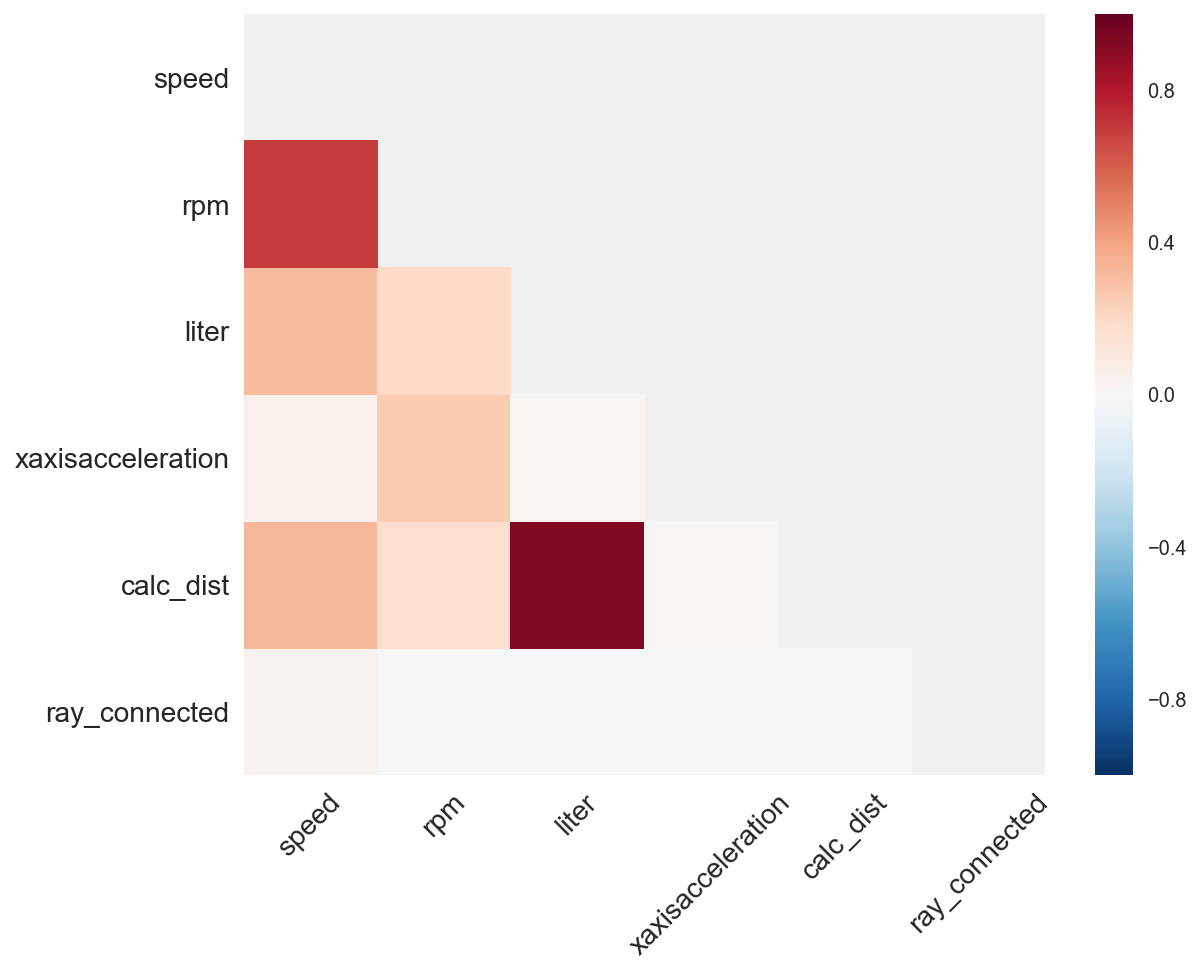

In [45]:
drive_sub_cols = ['speed','rpm','liter','xaxisacceleration','calc_dist','ray_connected']
corr = drive[drive_sub_cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))

ax = sns.heatmap(corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

#### <span style='color:midnightblue'> The following heatmap shows the correlation between variables in the summary DataFrame. </span>

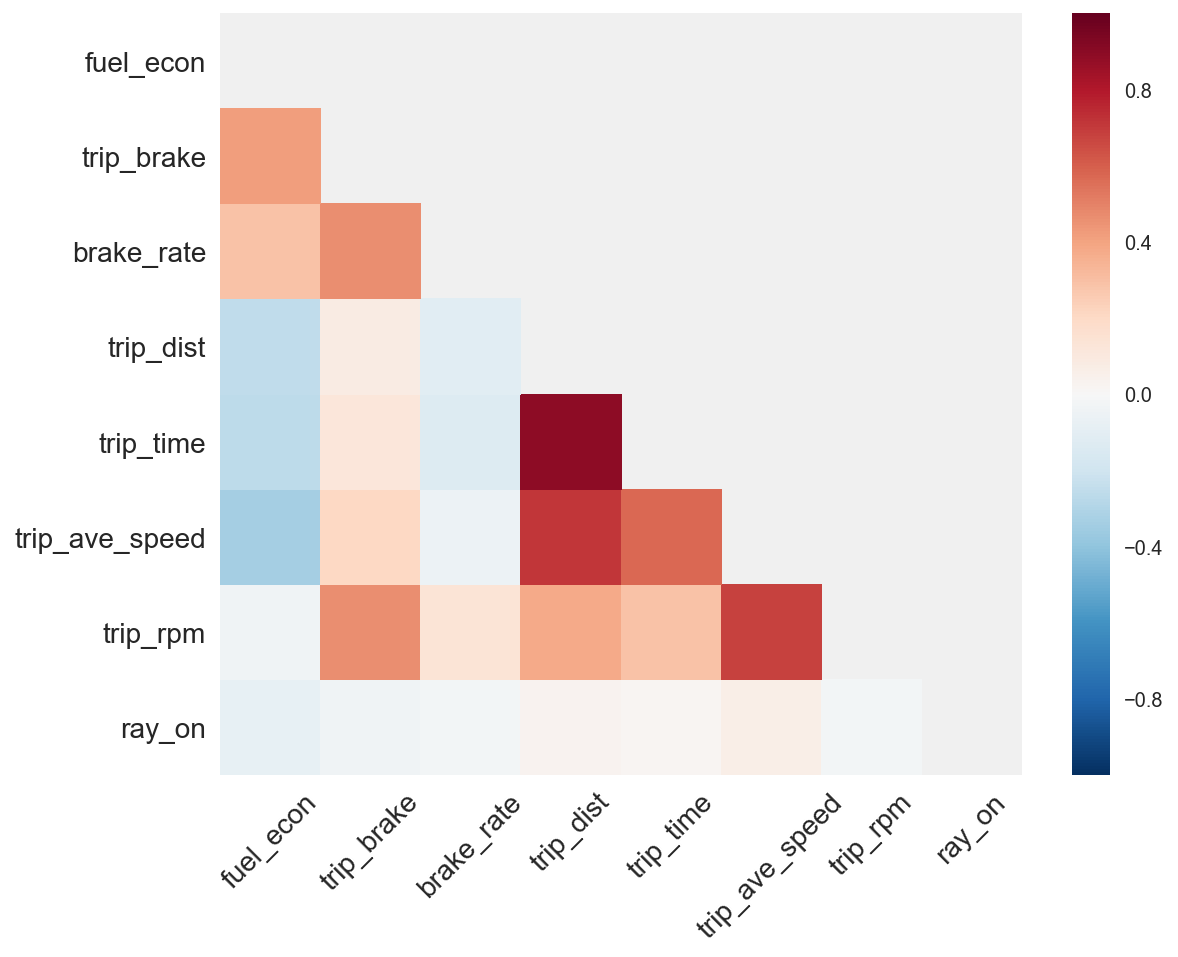

In [47]:
summ_trip_sub_cols = ['fuel_econ','trip_brake','brake_rate','trip_dist','trip_time','trip_ave_speed','trip_rpm','ray_on']
corr = summ_trip[summ_trip_sub_cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))

ax = sns.heatmap(corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

#### <span style='color:midnightblue'> Rather than standardising the data and plotting it on one boxplot, I'll plot the main variables separately, so the range of values can be seen. The code is longer, but I think that the result is more informative. All except speed, litres and acceleration are from the summary DataFrame. </span>

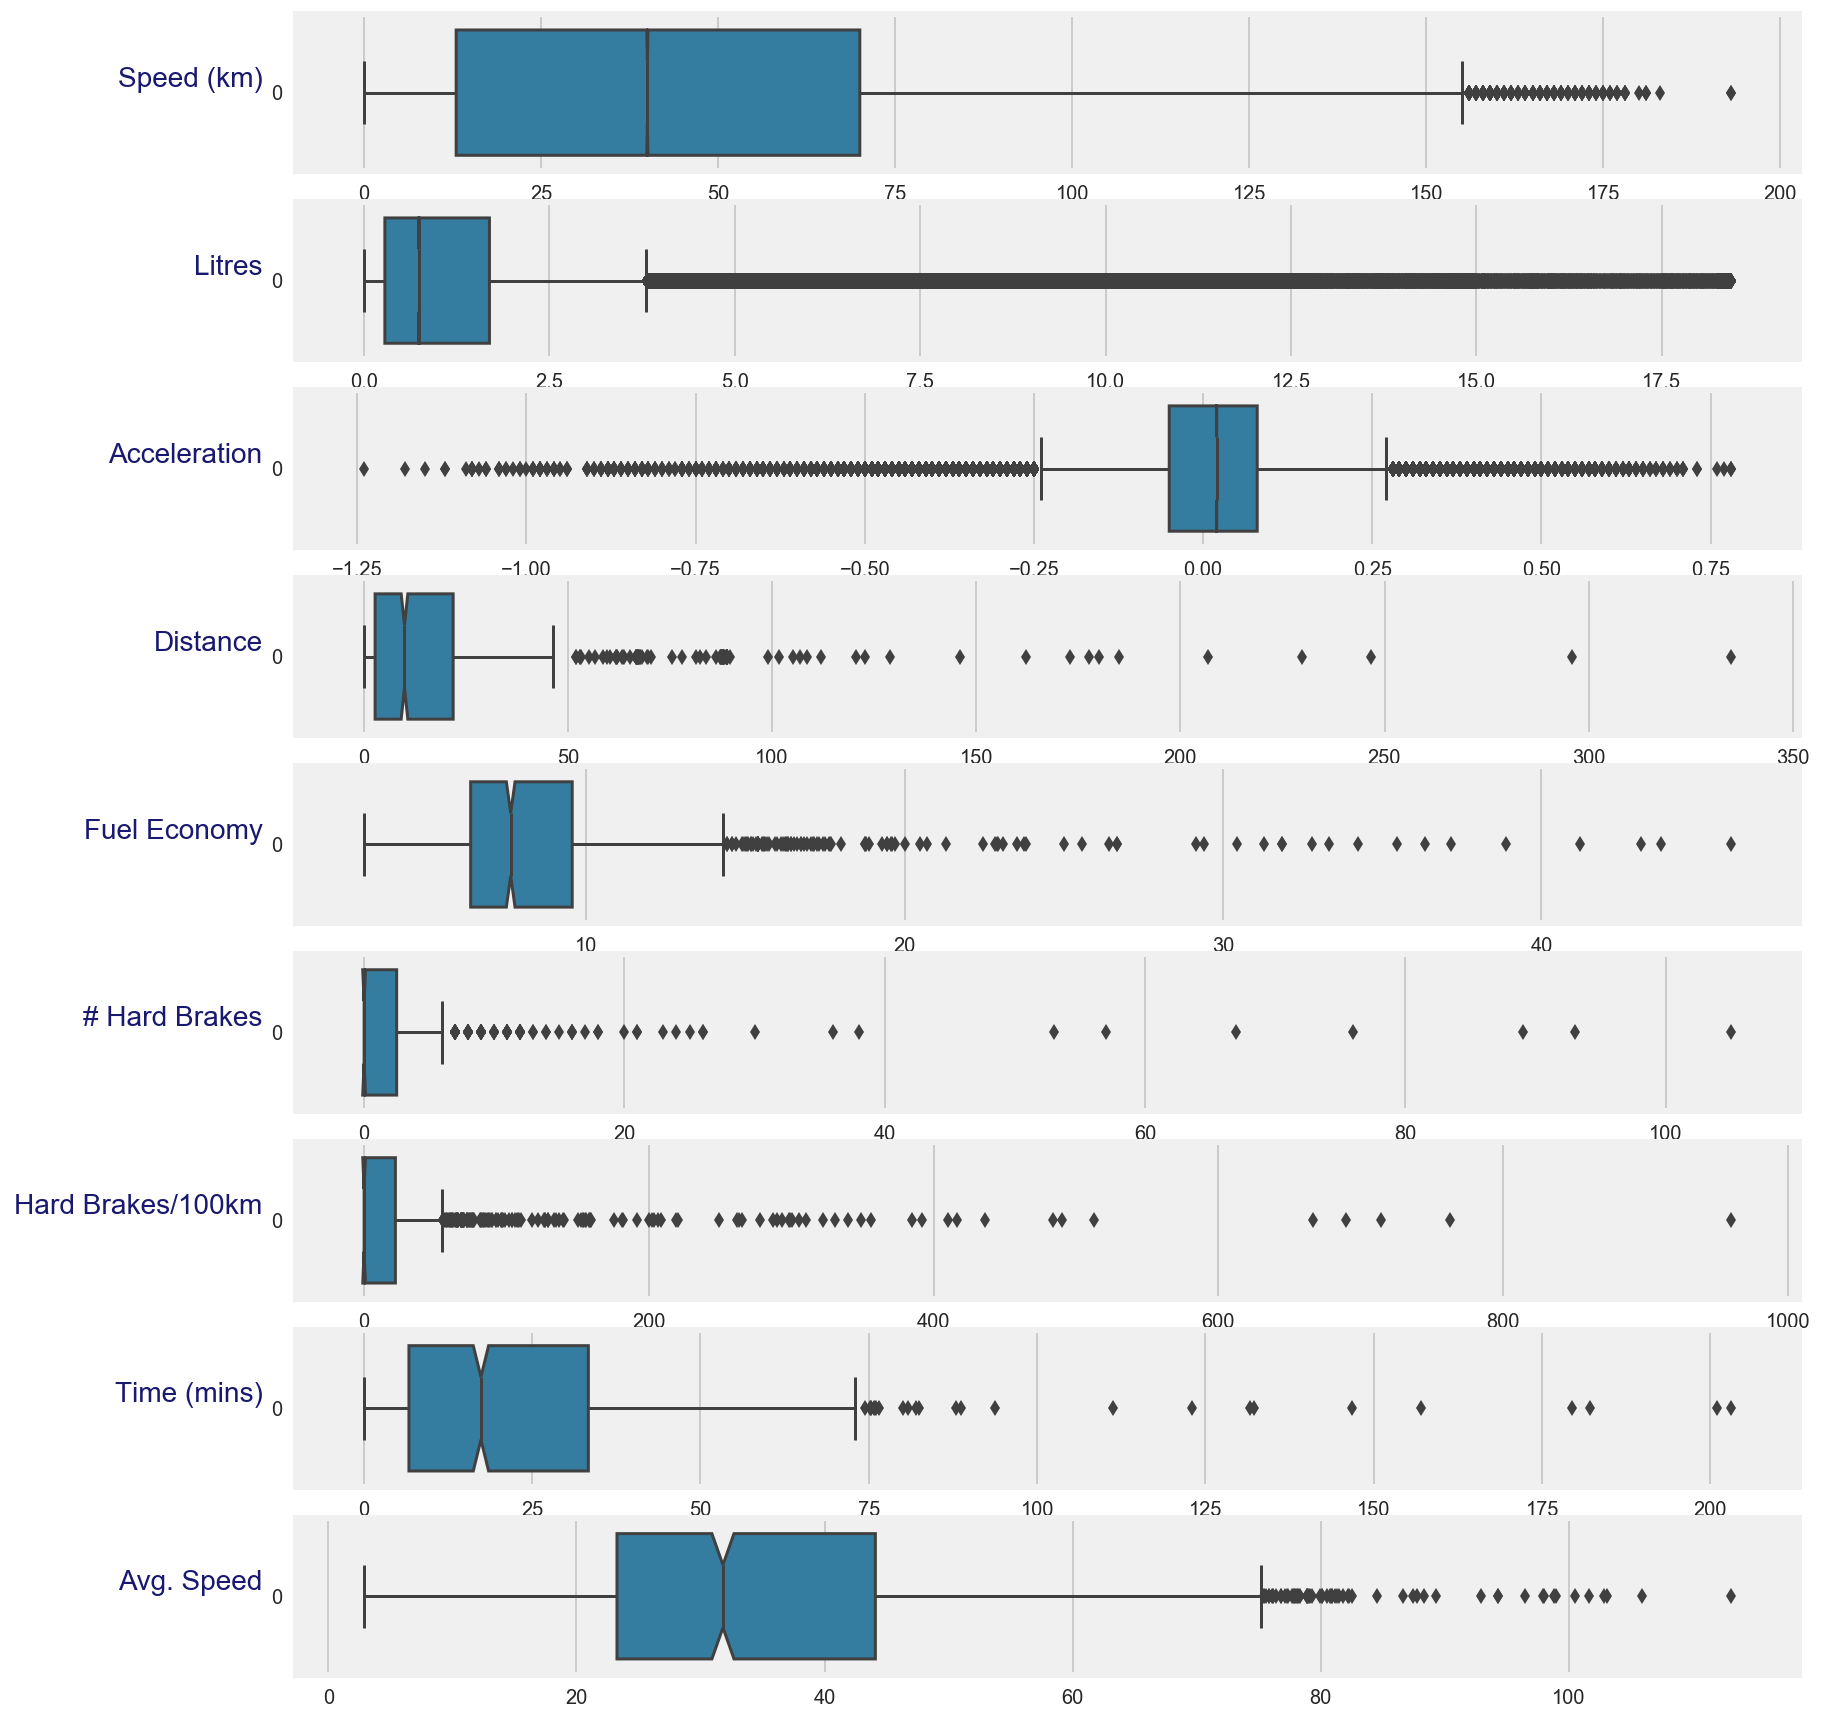

In [53]:
fig = plt.figure(figsize=(12,17))
ax1 = fig.add_subplot(10,1,1)
ax1 = sns.boxplot(data=drive.speed, orient="h", fliersize=6, linewidth=1.5, notch=True, saturation=0.5, ax=ax1)
ax1.set_ylabel("Speed (km)", size=14, rotation=0, ha='right')
ax1.yaxis.label.set_color('midnightblue')

ax2 = fig.add_subplot(10,1,2)
ax2 = sns.boxplot(data=drive.liter, orient="h", fliersize=6, linewidth=1.5, notch=True, saturation=0.5, ax=ax2)
ax2.set_ylabel("Litres", size=14, rotation=0, ha='right')
ax2.yaxis.label.set_color('midnightblue')

ax3 = fig.add_subplot(10,1,3)
ax3 = sns.boxplot(data=drive.xaxisacceleration, orient="h", fliersize=6,linewidth=1.5,notch=True,saturation=0.5,ax=ax3)
ax3.set_ylabel("Acceleration", size=14, rotation=0, ha='right')
ax3.yaxis.label.set_color('midnightblue')

ax4 = fig.add_subplot(10,1,4)
ax4 = sns.boxplot(data=summ_trip.trip_dist, orient="h", fliersize=6, linewidth=1.5, notch=True, saturation=0.5, ax=ax4)
ax4.set_ylabel("Distance", size=14, rotation=0, ha='right')
ax4.yaxis.label.set_color('midnightblue')

ax5 = fig.add_subplot(10,1,5)
ax5 = sns.boxplot(data=summ_trip.fuel_econ, orient="h", fliersize=6, linewidth=1.5, notch=True, saturation=0.5, ax=ax5)
ax5.set_ylabel("Fuel Economy", size=14, rotation=0, ha='right')
ax5.yaxis.label.set_color('midnightblue')

ax6 = fig.add_subplot(10,1,6)
ax6 = sns.boxplot(data=summ_trip.trip_brake, orient="h", fliersize=6, linewidth=1.5, notch=True, saturation=0.5, ax=ax6)
ax6.set_ylabel("# Hard Brakes", size=14, rotation=0, ha='right')
ax6.yaxis.label.set_color('midnightblue')

ax7 = fig.add_subplot(10,1,7)
ax7 = sns.boxplot(data=summ_trip.brake_rate, orient="h", fliersize=6, linewidth=1.5, notch=True, saturation=0.5, ax=ax7)
ax7.set_ylabel("Hard Brakes/100km", size=14, rotation=0, ha='right')
ax7.yaxis.label.set_color('midnightblue')

ax8 = fig.add_subplot(10,1,8)
ax8 = sns.boxplot(data=summ_trip.trip_time/60, orient="h",fliersize=6,linewidth=1.5,notch=True, saturation=0.5, ax=ax8)
ax8.set_ylabel("Time (mins)", size=14, rotation=0, ha='right')
ax8.yaxis.label.set_color('midnightblue')

ax9 = fig.add_subplot(10,1,9)
ax9 = sns.boxplot(data=summ_trip.trip_ave_speed, orient="h",fliersize=6,linewidth=1.5,notch=True,saturation=0.5,ax=ax9)
ax9.set_ylabel("Avg. Speed", size=14, rotation=0, ha='right')
ax9.yaxis.label.set_color('midnightblue')

#### <span style='color:midnightblue'> Let's get an idea of the extent of the data by seeing how many trips there are. </span>

In [55]:
summ_dr_ray_on = summ_trip[summ_trip.ray_on == 1].groupby('driver_id').ray_on.count()
summ_dr_ray_off = summ_trip[summ_trip.ray_on == 0].groupby('driver_id').ray_on.count()
summ_dr_ray = pd.DataFrame({'ray_on':summ_dr_ray_on, 'ray_off':summ_dr_ray_off})
summ_dr_ray = pd.DataFrame(summ_dr_ray.to_records())

summ_dr_ray.driver_id = summ_dr_ray.driver_id.astype(int)
summ_dr_ray = summ_dr_ray.sort_values(by = 'driver_id')
summ_dr_ray.driver_id = summ_dr_ray.driver_id.astype(str)
summ_dr_ray.reset_index(drop=True, inplace=True)
print (summ_dr_ray.head(2))

  driver_id  ray_off  ray_on
0         1       62      89
1         3       67      19


#### <span style='color:midnightblue'> I'll visualise this by plotting the number of trips per driver, split for when the Ray is on and off. </span>

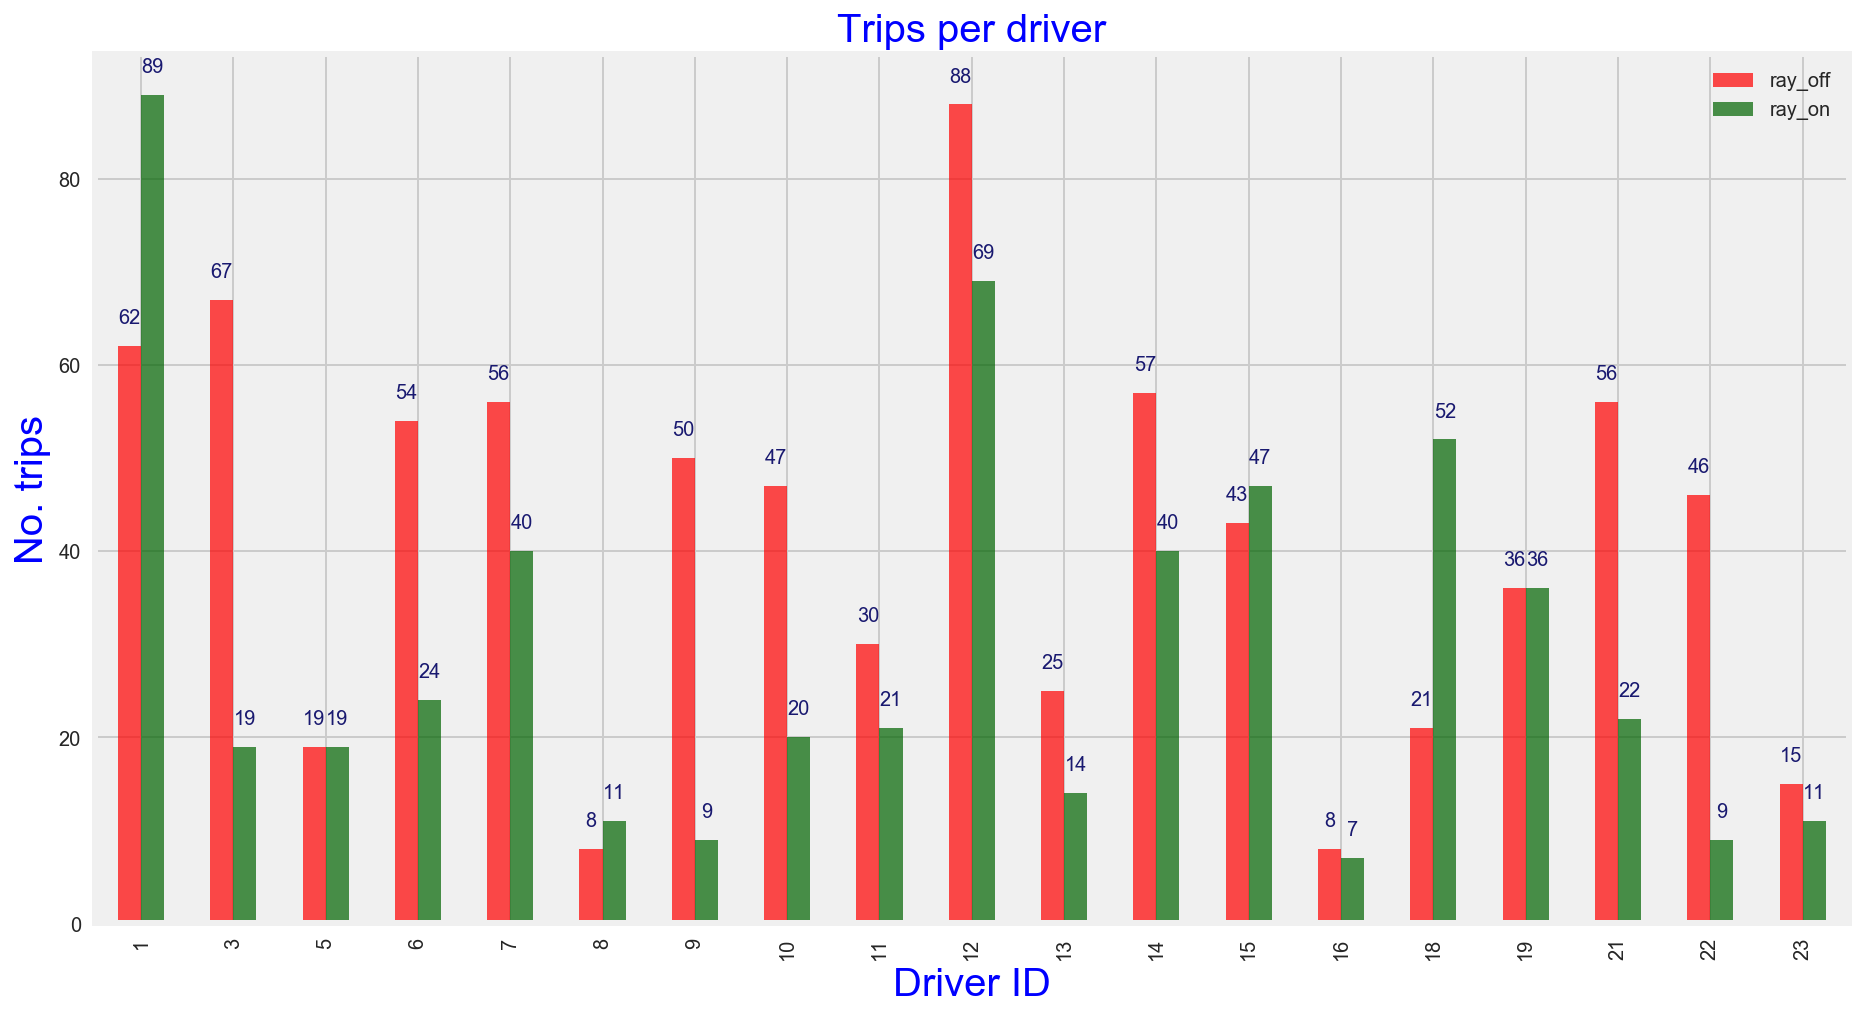

In [60]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()
ax = summ_dr_ray.plot.bar(ax=ax, color=['red', 'darkgreen'], alpha=0.7)
ax.set_xticklabels(summ_dr_ray.driver_id)
ax.set_xlabel("Driver ID", size=20, color='blue')
ax.set_ylabel("No. trips", size=20, color='blue')
plt.title('Trips per driver', size=20, color = 'blue')

bars = ax.patches 
values = []
for i in range(len(summ_dr_ray)):
    values.append(summ_dr_ray.ray_off[i])
for i in range(len(summ_dr_ray)):
    values.append(summ_dr_ray.ray_on[i])
    
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 2, value, ha='center', va='bottom', color='midnightblue')

plt.show()

#### <span style='color:midnightblue'> There is quite a range. I will keep in mind later when analysing the data that some drivers don't have many trips at all. </span>

#### <span style='color:midnightblue'> I'll also plot the fuel economy per driver, again separating trips with the Ray on and off. </span>

In [62]:
summ_fuel_ray_on = (summ_trip[summ_trip.ray_on == 1].groupby('driver_id').fuel_used.sum() / 
                    summ_trip[summ_trip.ray_on == 1].groupby('driver_id').trip_dist.sum()) * 100
summ_fuel_ray_off = (summ_trip[summ_trip.ray_on == 0].groupby('driver_id').fuel_used.sum() / 
                    summ_trip[summ_trip.ray_on == 0].groupby('driver_id').trip_dist.sum()) * 100
summ_fuel_ray = pd.DataFrame({'ray_on':summ_fuel_ray_on, 'ray_off':summ_fuel_ray_off})
summ_fuel_ray = pd.DataFrame(summ_fuel_ray.to_records())
summ_fuel_ray.driver_id = summ_fuel_ray.driver_id.astype(int)
summ_fuel_ray = summ_fuel_ray.sort_values(by = 'driver_id')
summ_fuel_ray.driver_id = summ_fuel_ray.driver_id.astype(str)
summ_fuel_ray.reset_index(drop=True, inplace=True)

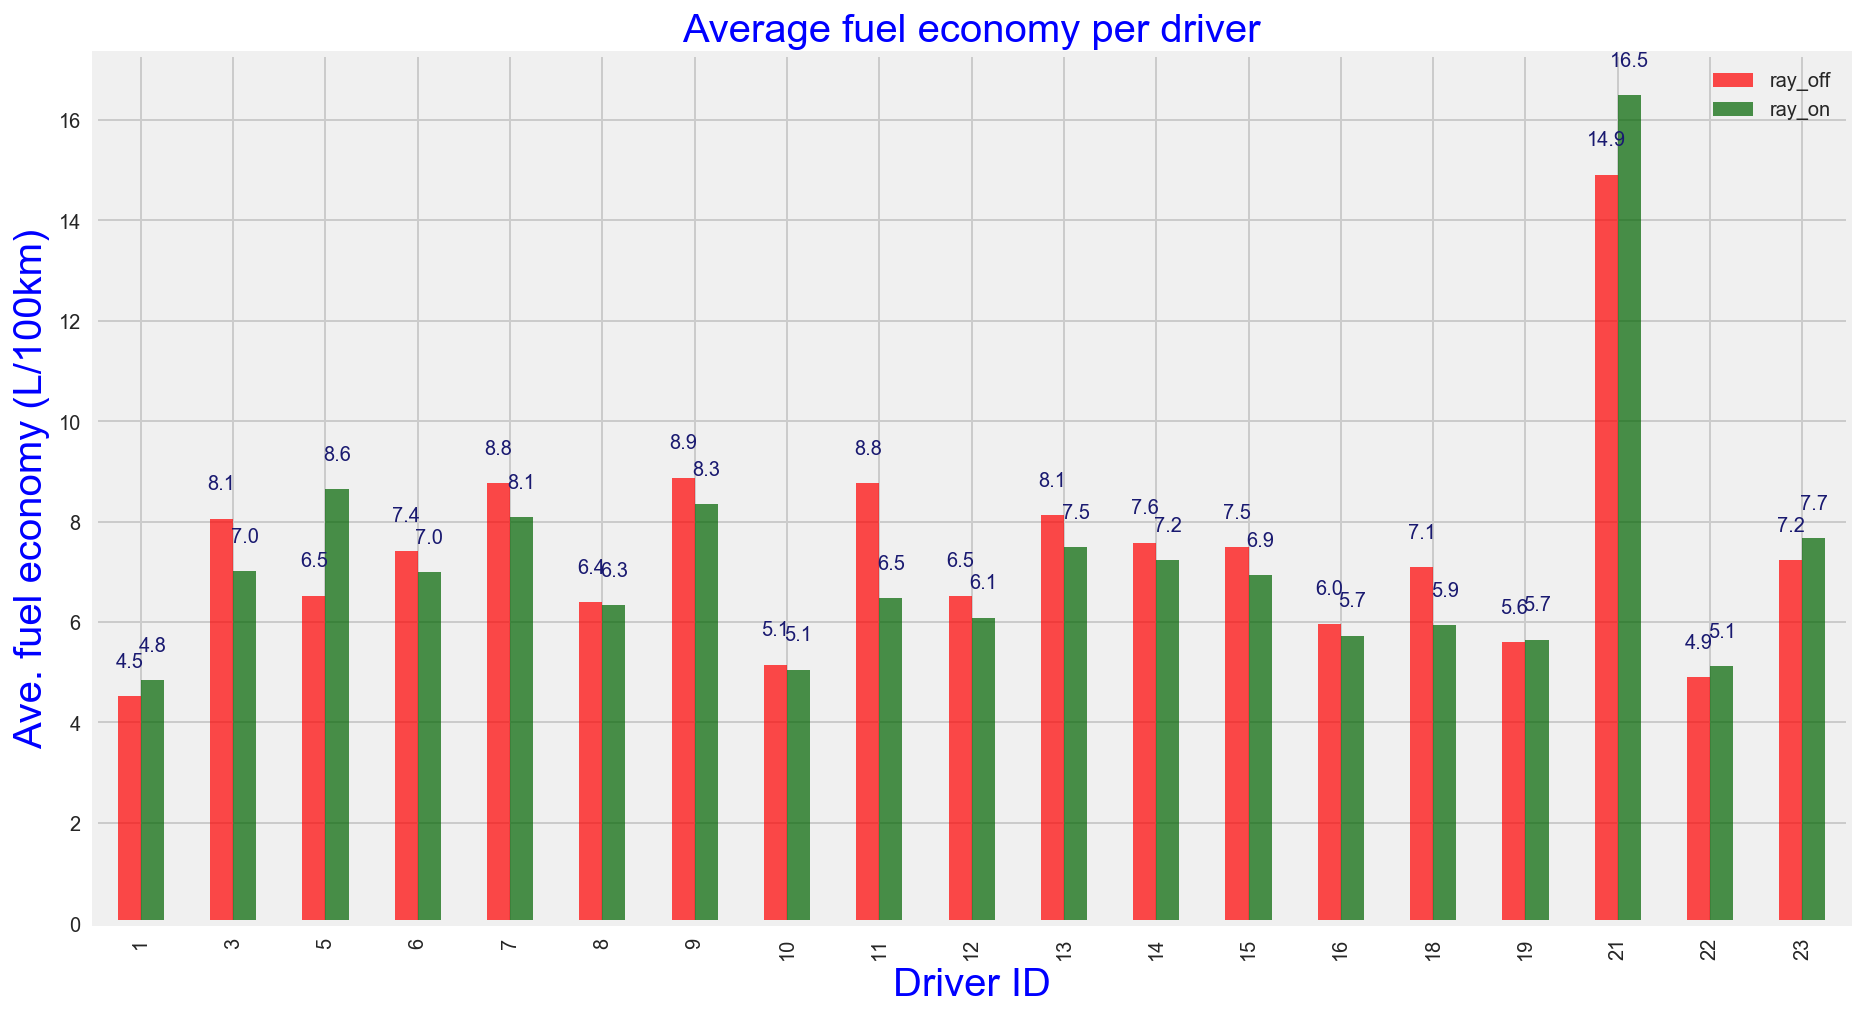

In [63]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()
ax = summ_fuel_ray.plot.bar(ax=ax, color=['red', 'darkgreen'], alpha=0.7)
ax.set_xticklabels(summ_fuel_ray.driver_id)
ax.set_xlabel("Driver ID", size=20, color='blue')
ax.set_ylabel("Ave. fuel economy (L/100km)", size=20, color='blue')
plt.title('Average fuel economy per driver', size=20, color='blue')

bars = ax.patches
values = []
for i in (summ_fuel_ray.index):
    values.append(summ_fuel_ray.ray_off[i])
for i in (summ_fuel_ray.index):
    values.append(summ_fuel_ray.ray_on[i])
    
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, round(value,1), ha='center', va='bottom', color='midnightblue')

plt.show()

#### <span style='color:midnightblue'> Again, there is quite a range. </span>

#### <span style='color:midnightblue'> Lastly, the average trip time. </span>

In [65]:
summ_mins_ray_on = summ_trip[summ_trip.ray_on == 1].groupby('driver_id').trip_time.mean() / 60
summ_mins_ray_off = summ_trip[summ_trip.ray_on == 0].groupby('driver_id').trip_time.mean() / 60
summ_mins_ray = pd.DataFrame({'ray_on':summ_mins_ray_on, 'ray_off':summ_mins_ray_off})
summ_mins_ray = pd.DataFrame(summ_mins_ray.to_records())
summ_mins_ray.driver_id = summ_mins_ray.driver_id.astype(int)
summ_mins_ray = summ_mins_ray.sort_values(by = 'driver_id')
summ_mins_ray.driver_id = summ_mins_ray.driver_id.astype(str)
summ_mins_ray.reset_index(drop=True, inplace=True)

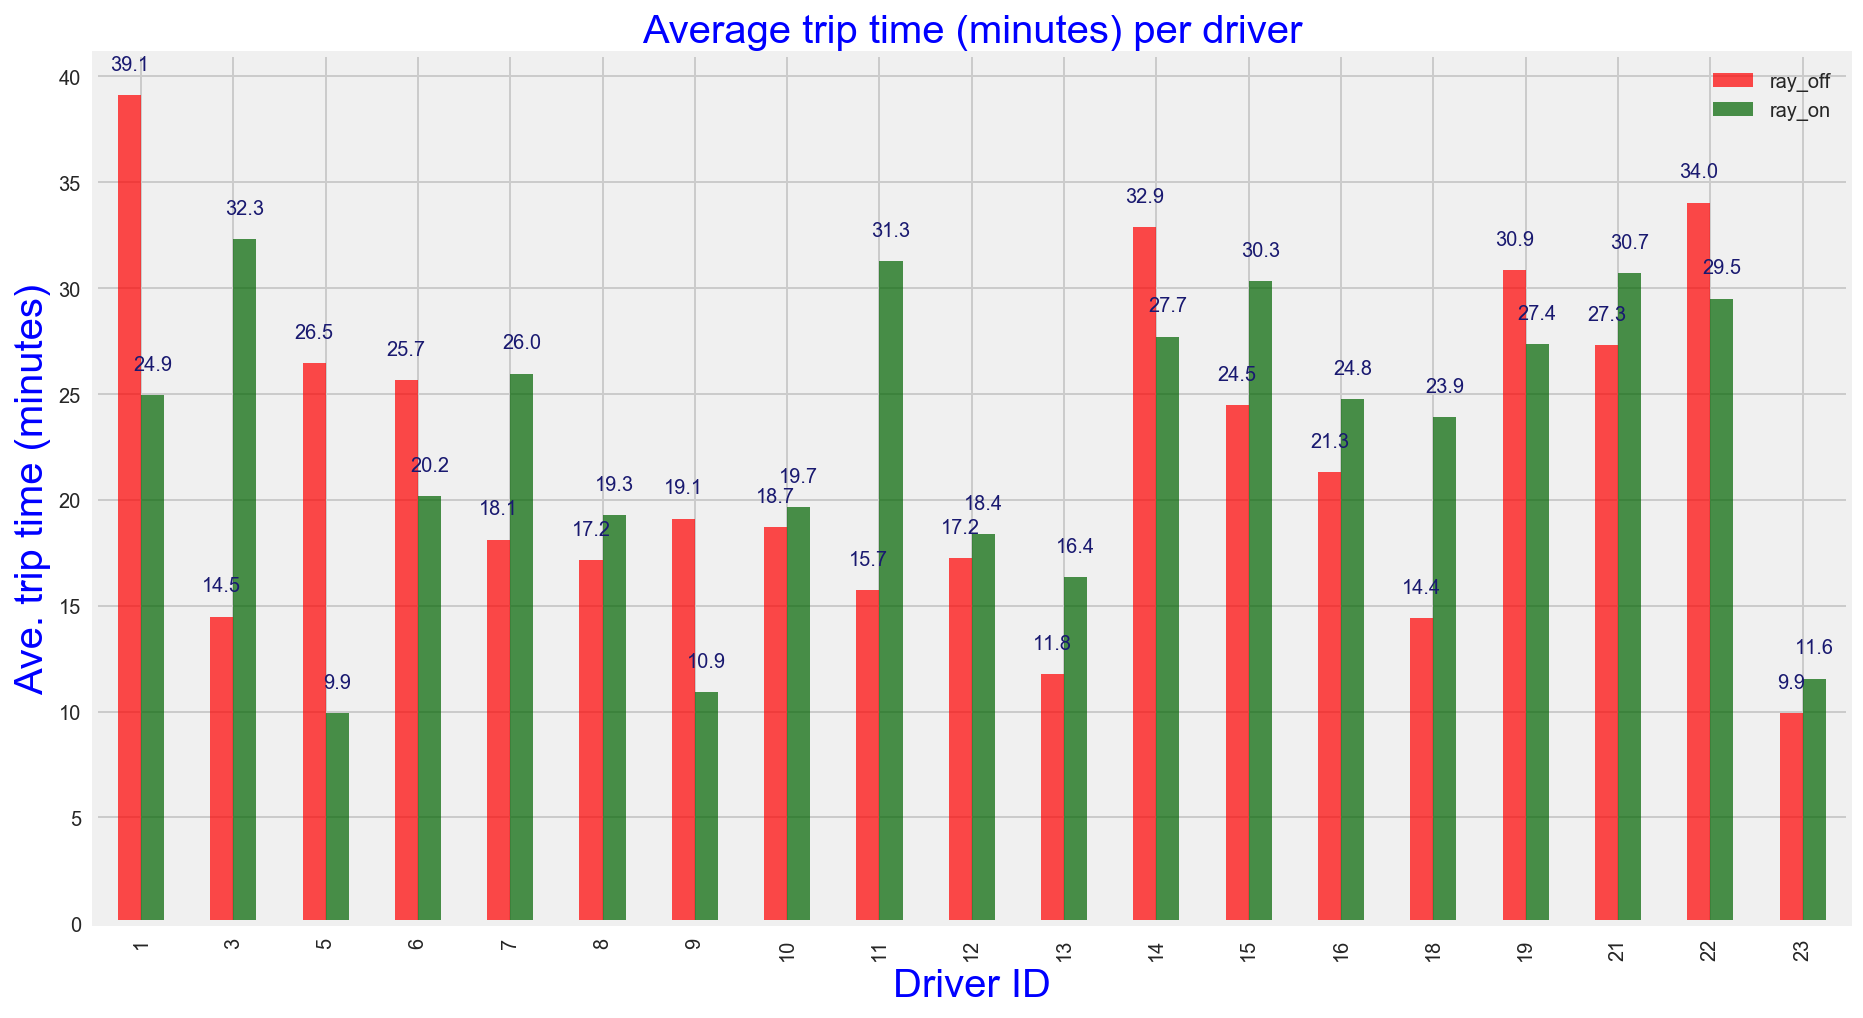

In [66]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()
ax = summ_mins_ray.plot.bar(ax=ax, color=['red', 'darkgreen'], alpha=0.7)
ax.set_xticklabels(summ_mins_ray.driver_id)
ax.set_xlabel("Driver ID", size=20, color='blue')
ax.set_ylabel("Ave. trip time (minutes)", size=20, color='blue')
plt.title('Average trip time (minutes) per driver', size=20, color='blue')

bars = ax.patches
values = []
for i in (summ_mins_ray.index):
    values.append(summ_mins_ray.ray_off[i])
for i in (summ_mins_ray.index):
    values.append(summ_mins_ray.ray_on[i])

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, round(value,1), ha='center', va='bottom', color='midnightblue')

plt.show()

#### <span style='color:midnightblue'> I'd like to get an idea of the fuel economy overall for all drivers, with and without the Ray. I'll do this with a distribution plot. </span>



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



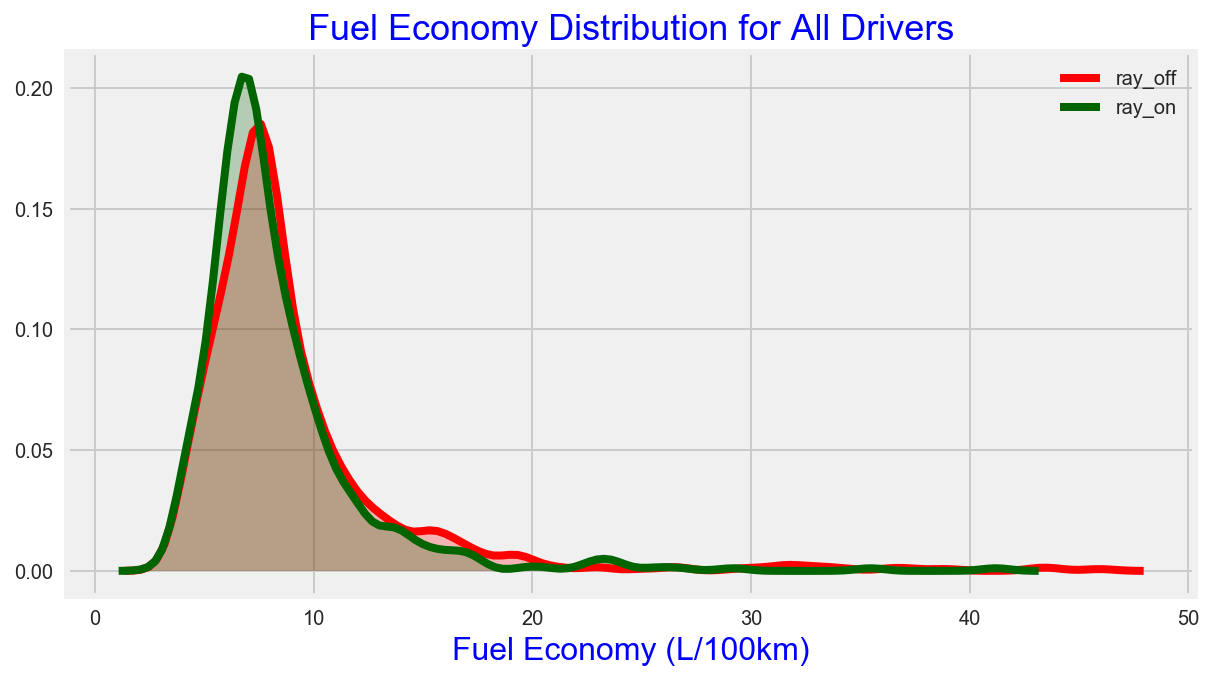

In [69]:
fig, ax = plt.subplots(figsize=(9,5))
for i, bn in enumerate(['ray_off', 'ray_on']):
    colors=['red', 'darkgreen']
    ax = sns.distplot(summ_trip[summ_trip.ray_on == i].fuel_econ, hist=False, kde=True, color=colors[i], 
                      kde_kws={'shade':True}, label=bn)
ax.legend(loc='upper right')
plt.title('Fuel Economy Distribution for All Drivers', size=18, color = 'blue')
ax.set_xlabel("Fuel Economy (L/100km)", size=16, color='blue')

mu = summ_trip.fuel_econ.mean()
std = summ_trip.fuel_econ.std()
plt.show()

#### <span style='color:midnightblue'> It appears that the fuel economy is slightly less in total for when the Ray is on. </span>

#### <span style='color:midnightblue'> I'll also draw a distribution plot for each of the 19 drivers individually. </span>

In [72]:
def plot_multi_fuel(ray, a=None,b=None,c=None,d=None,e=None):
    if e != None:
        fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(15,6))
    else:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,6))
    colors=['red', 'darkgreen']
    
    for i, bn in enumerate(ray):
        ax1 = sns.distplot(summ_trip[(summ_trip.ray_on == i) & (summ_trip.driver_id == a)].fuel_econ, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax1)
    ax1.legend(loc='upper right')
    ax1.set_title('Driver '+ a, size = 14, color='blue')
    ax1.set_xlabel("Fuel Economy (L/100km)", size=10, color='blue')

    for i, bn in enumerate(ray):
        ax2 = sns.distplot(summ_trip[(summ_trip.ray_on == i) & (summ_trip.driver_id == b)].fuel_econ, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax2)
    ax2.legend(loc='upper right')
    ax2.set_title('Driver '+ b, size = 14, color='blue')
    ax2.set_xlabel("Fuel Economy (L/100km)", size=10, color='blue')
    
    for i, bn in enumerate(ray):
        ax3 = sns.distplot(summ_trip[(summ_trip.ray_on == i) & (summ_trip.driver_id == c)].fuel_econ, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax3)
    ax3.legend(loc='upper right')
    ax3.set_title('Driver '+ c, size = 14, color='blue')
    ax3.set_xlabel("Fuel Economy (L/100km)", size=10, color='blue')

    for i, bn in enumerate(ray):
        ax4 = sns.distplot(summ_trip[(summ_trip.ray_on == i) & (summ_trip.driver_id == d)].fuel_econ, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax4)
    ax4.legend(loc='upper right')
    ax4.set_title('Driver '+ d, size = 14, color='blue')
    ax4.set_xlabel("Fuel Economy (L/100km)", size=10, color='blue')
    
    if e != None:
        for i, bn in enumerate(ray):
            ax5 = sns.distplot(summ_trip[(summ_trip.ray_on == i) & (summ_trip.driver_id == e)].fuel_econ, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax5)
        ax5.legend(loc='upper right')
        ax5.set_title('Driver '+ e, size = 14, color='blue')
        ax5.set_xlabel("Fuel Economy (L/100km)", size=10, color='blue')

    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



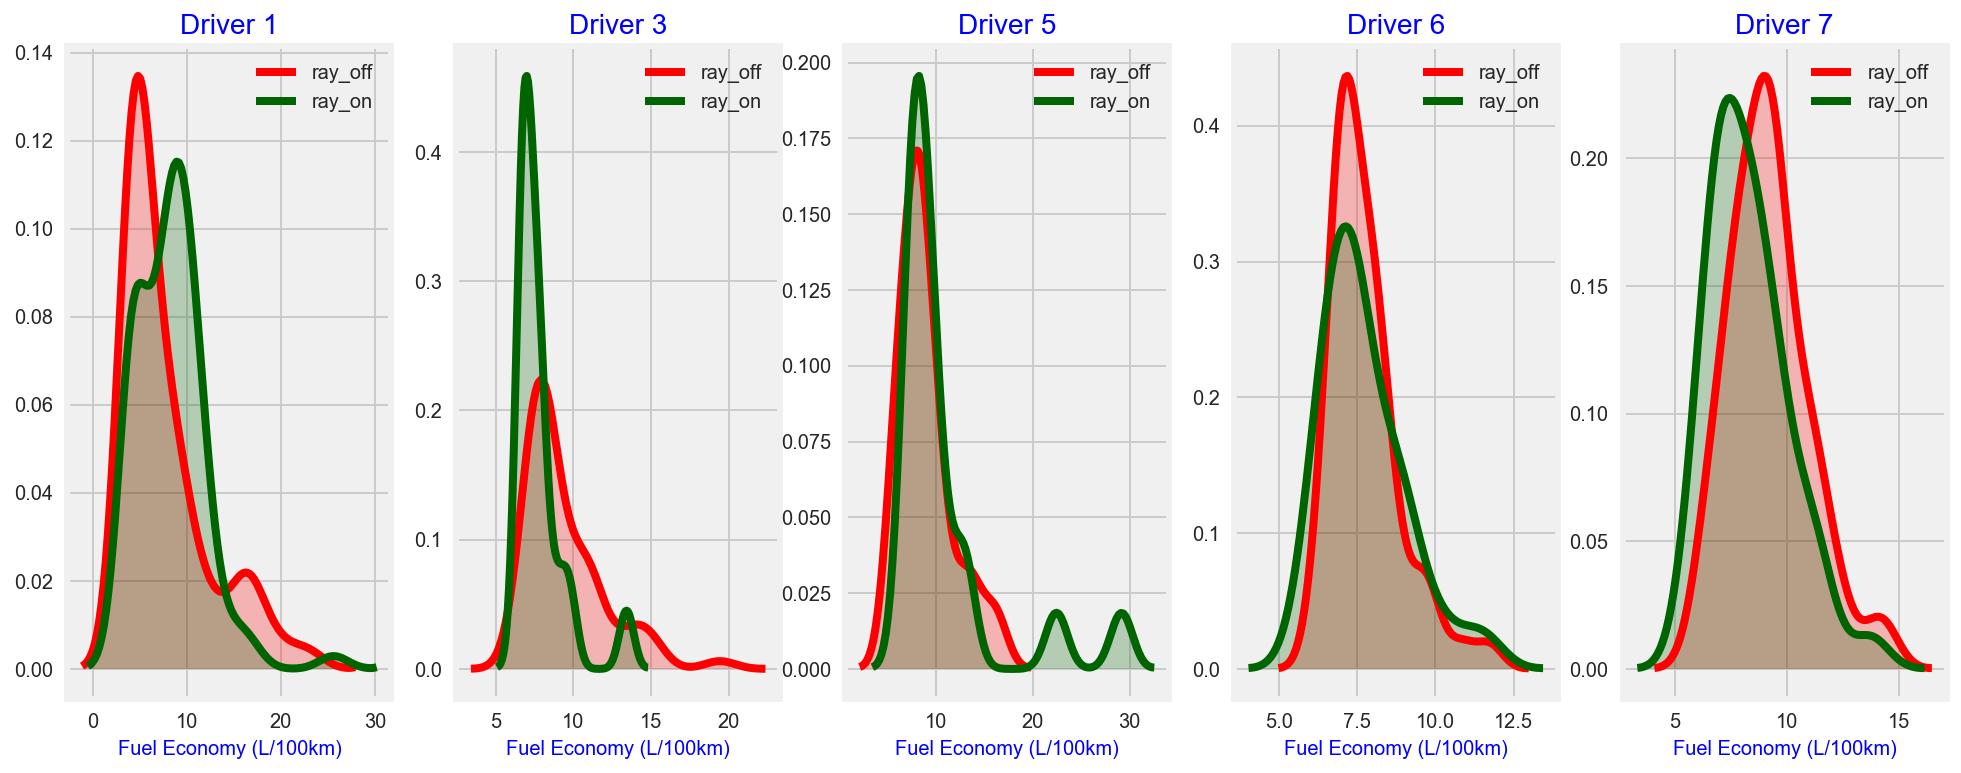

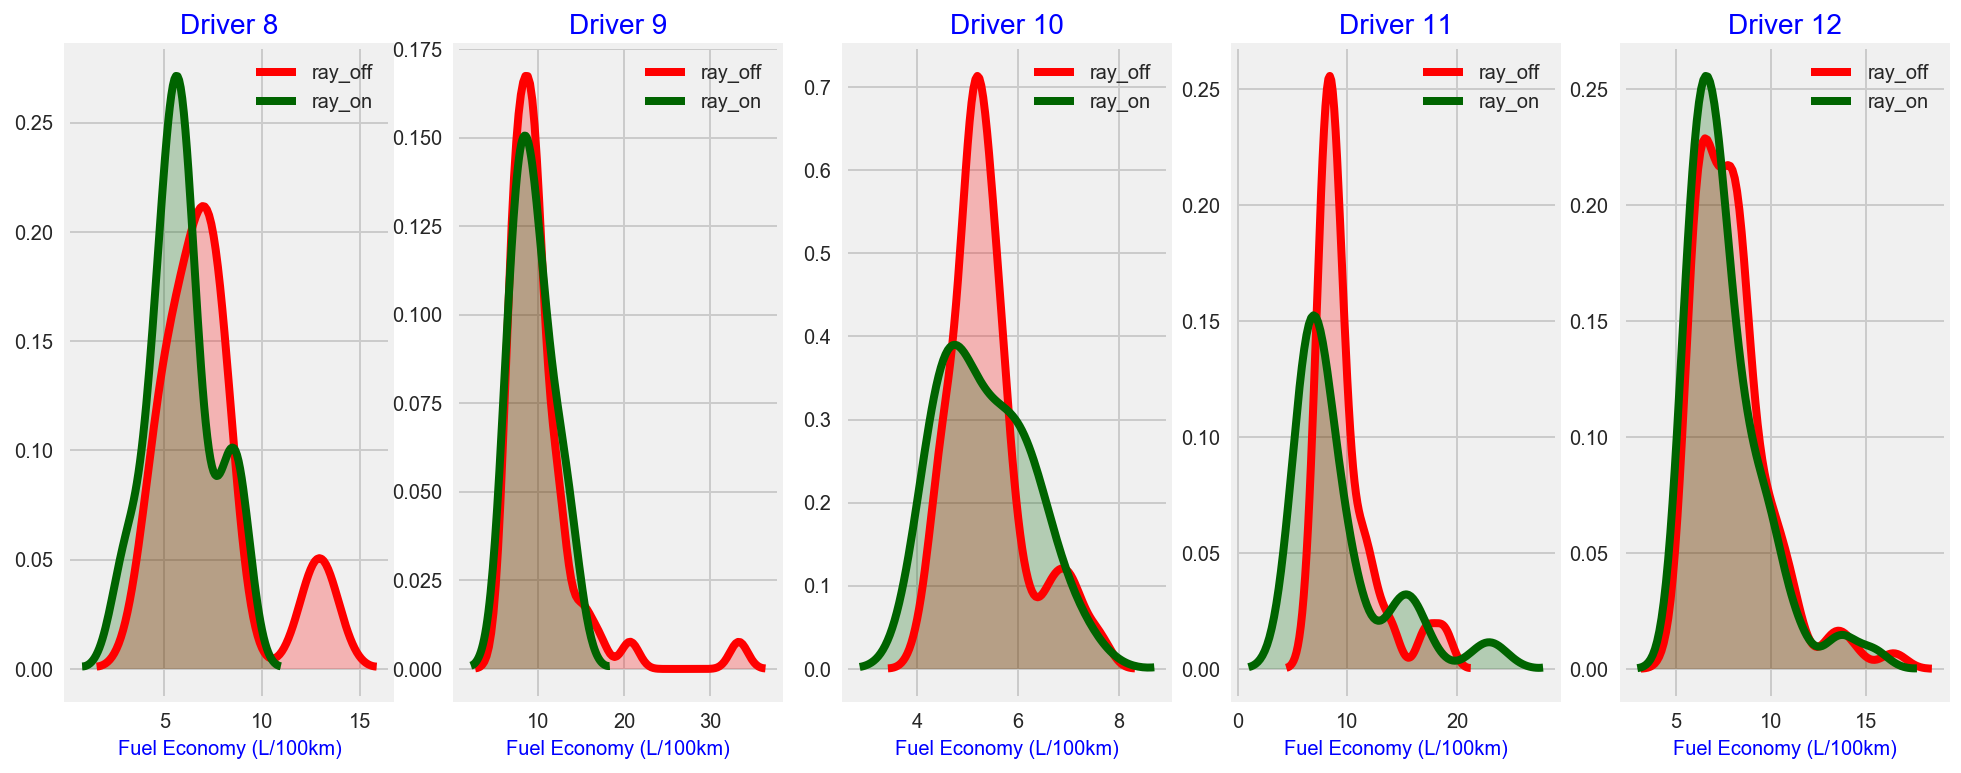

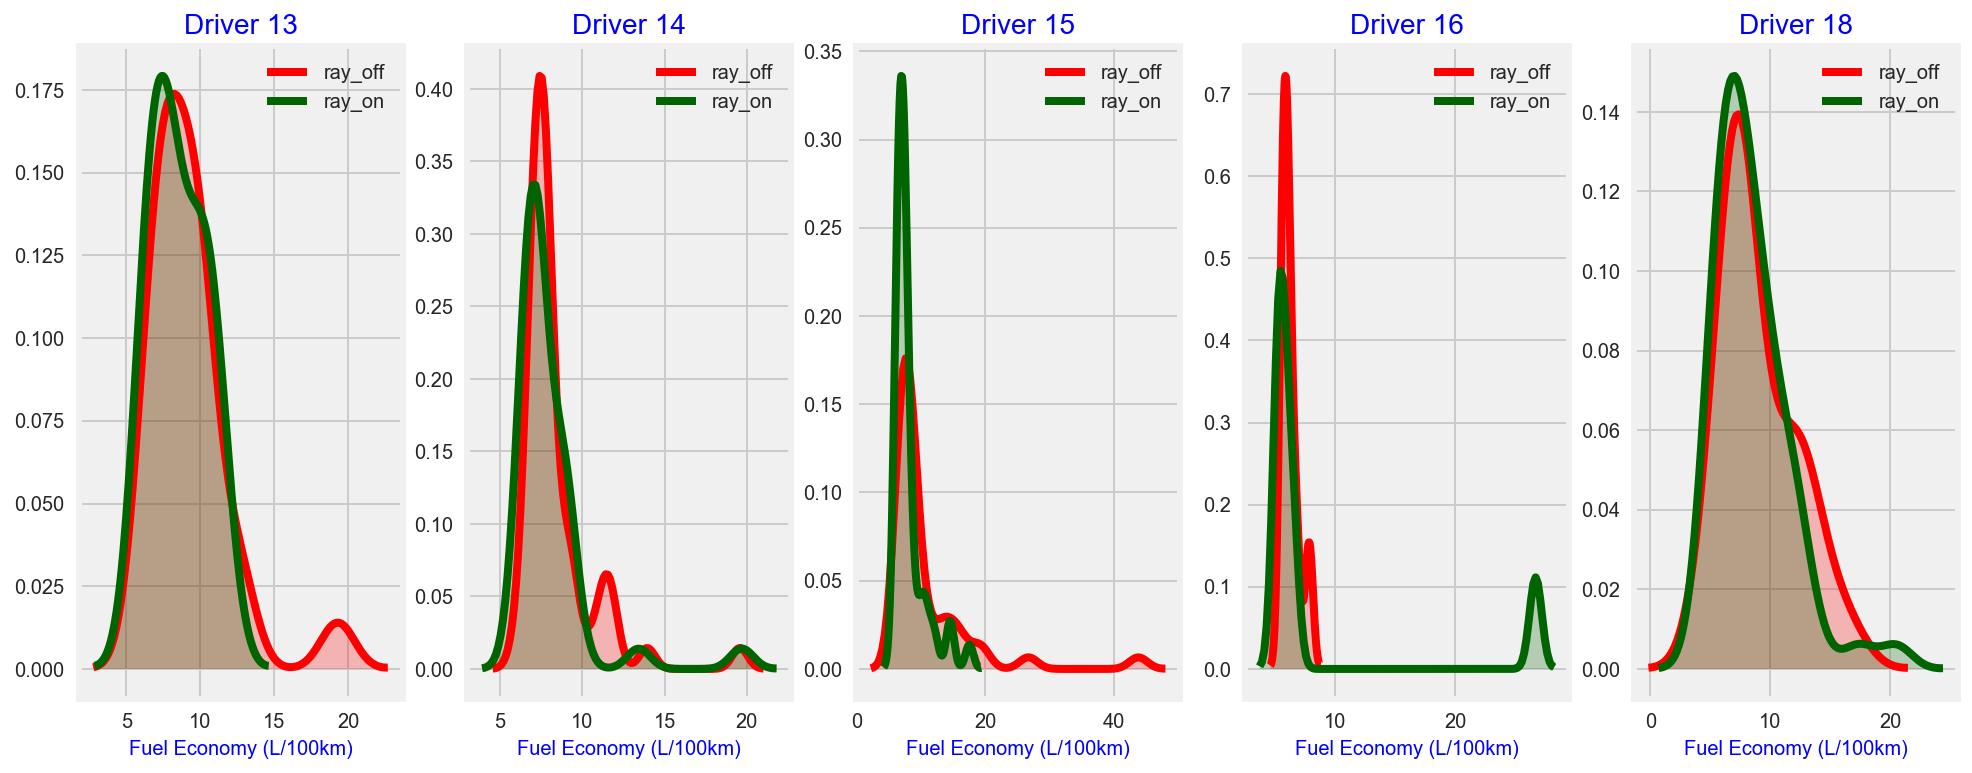

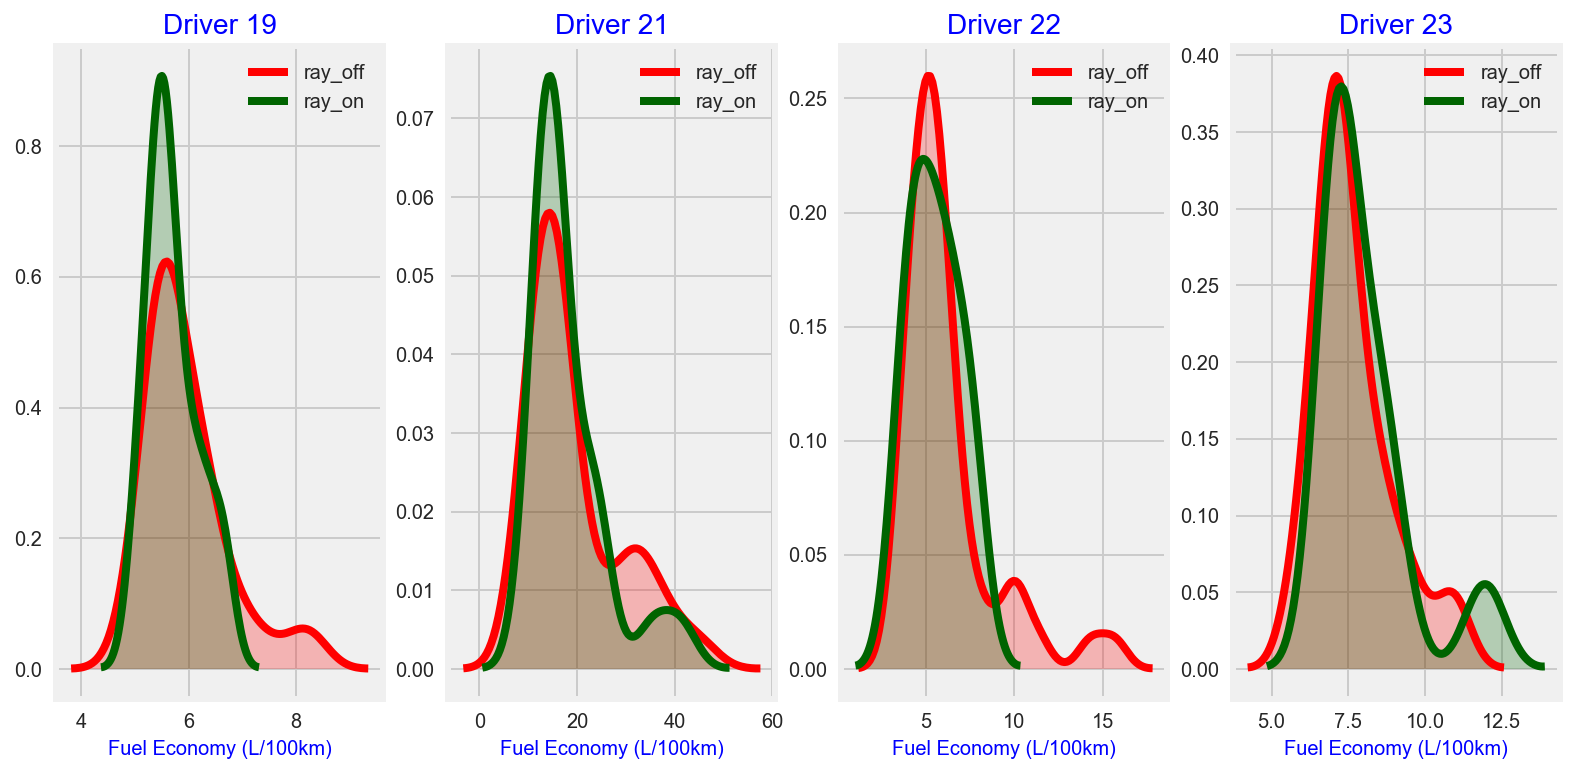

In [73]:
plot_multi_fuel(['ray_off', 'ray_on'], '1','3','5','6','7')
plot_multi_fuel(['ray_off', 'ray_on'], '8','9','10','11','12')
plot_multi_fuel(['ray_off', 'ray_on'], '13','14','15','16','18')
plot_multi_fuel(['ray_off', 'ray_on'], '19','21','22','23')

#### <span style='color:midnightblue'> There is quite a difference amongst individual drivers. Many have 'bumps' at higher fuel economies that I'm suspicious of. They could indicate outliers or some other problem with the data. </span>

#### <span style='color:midnightblue'> I'm going to plot the distributions for xaxisacceleration variable as well. This may give some idea of how much hard braking is going on. </span>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



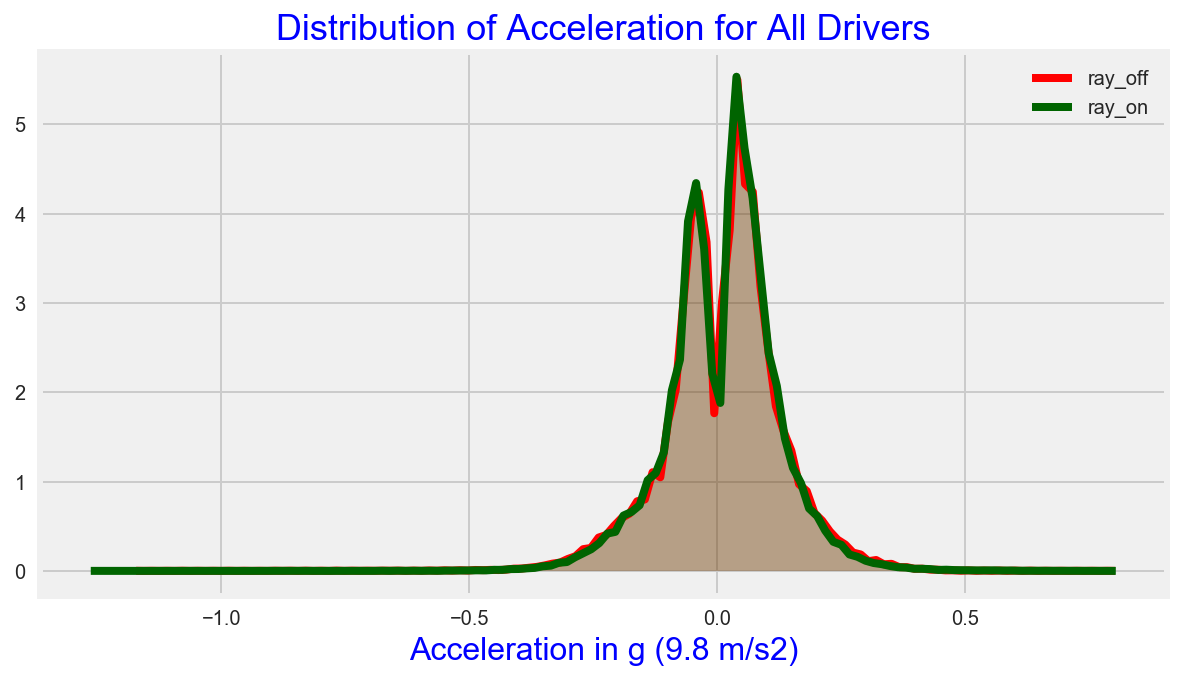

In [85]:
fig, ax = plt.subplots(figsize=(9,5))
for i, bn in enumerate(['ray_off', 'ray_on']):
    colors=['red', 'darkgreen']
    ax = sns.distplot(drive[drive.ray_connected == i].xaxisacceleration, hist=False, kde=True, color=colors[i], 
                      kde_kws={'shade':True}, label=bn)
ax.legend(loc='upper right')
plt.title('Fuel Acceleration for All Trips')
plt.title('Distribution of Acceleration for All Drivers', size = 18, color = 'blue')
ax.set_xlabel("Acceleration in g (9.8 m/s2)", size=16, color='blue')

plt.show()

#### <span style='color:midnightblue'> There doesn't look to be much difference across all drivers as a whole. </span>

In [78]:
def plot_multi_xaxis(ray, a=None,b=None,c=None,d=None,e=None):
    if e != None:
        fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(15,6))
    else:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,6))
    colors=['red', 'darkgreen']
    
    for i, bn in enumerate(ray):
        ax1 = sns.distplot(drive[(drive.ray_connected == i) & (drive.driver_id == a)].xaxisacceleration, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax1)
    ax1.legend(loc='upper left')
    ax1.set_title('Driver '+ a, size = 14, color='blue')
    ax1.set_xlabel("Acceleration in g units", size=10, color='blue')

    for i, bn in enumerate(ray):
        ax2 = sns.distplot(drive[(drive.ray_connected == i) & (drive.driver_id == b)].xaxisacceleration, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax2)
    ax2.legend(loc='upper left')
    ax2.set_title('Driver '+ b, size = 14, color='blue')
    ax2.set_xlabel("Acceleration in g units", size=10, color='blue')
    
    for i, bn in enumerate(ray):
        ax3 = sns.distplot(drive[(drive.ray_connected == i) & (drive.driver_id == c)].xaxisacceleration, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax3)
    ax3.legend(loc='upper left')
    ax3.set_title('Driver '+ c, size = 14, color='blue')
    ax3.set_xlabel("Acceleration in g units", size=10, color='blue')

    for i, bn in enumerate(ray):
        ax4 = sns.distplot(drive[(drive.ray_connected == i) & (drive.driver_id == d)].xaxisacceleration, hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax4)
    ax4.legend(loc='upper left')
    ax4.set_title('Driver '+ d, size = 14, color='blue')
    ax4.set_xlabel("Acceleration in g units", size=10, color='blue')
    
    if e != None:
        for i, bn in enumerate(ray):
            ax5 = sns.distplot(drive[(drive.ray_connected == i) & (drive.driver_id == e)].xaxisacceleration,hist=False, 
                           kde=True, color=colors[i], kde_kws={'shade':True}, label=bn, ax=ax5)
        ax5.legend(loc='upper left')
        ax5.set_title('Driver '+ e, size = 14, color='blue')
        ax5.set_xlabel("Acceleration in g units", size=10, color='blue')

    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



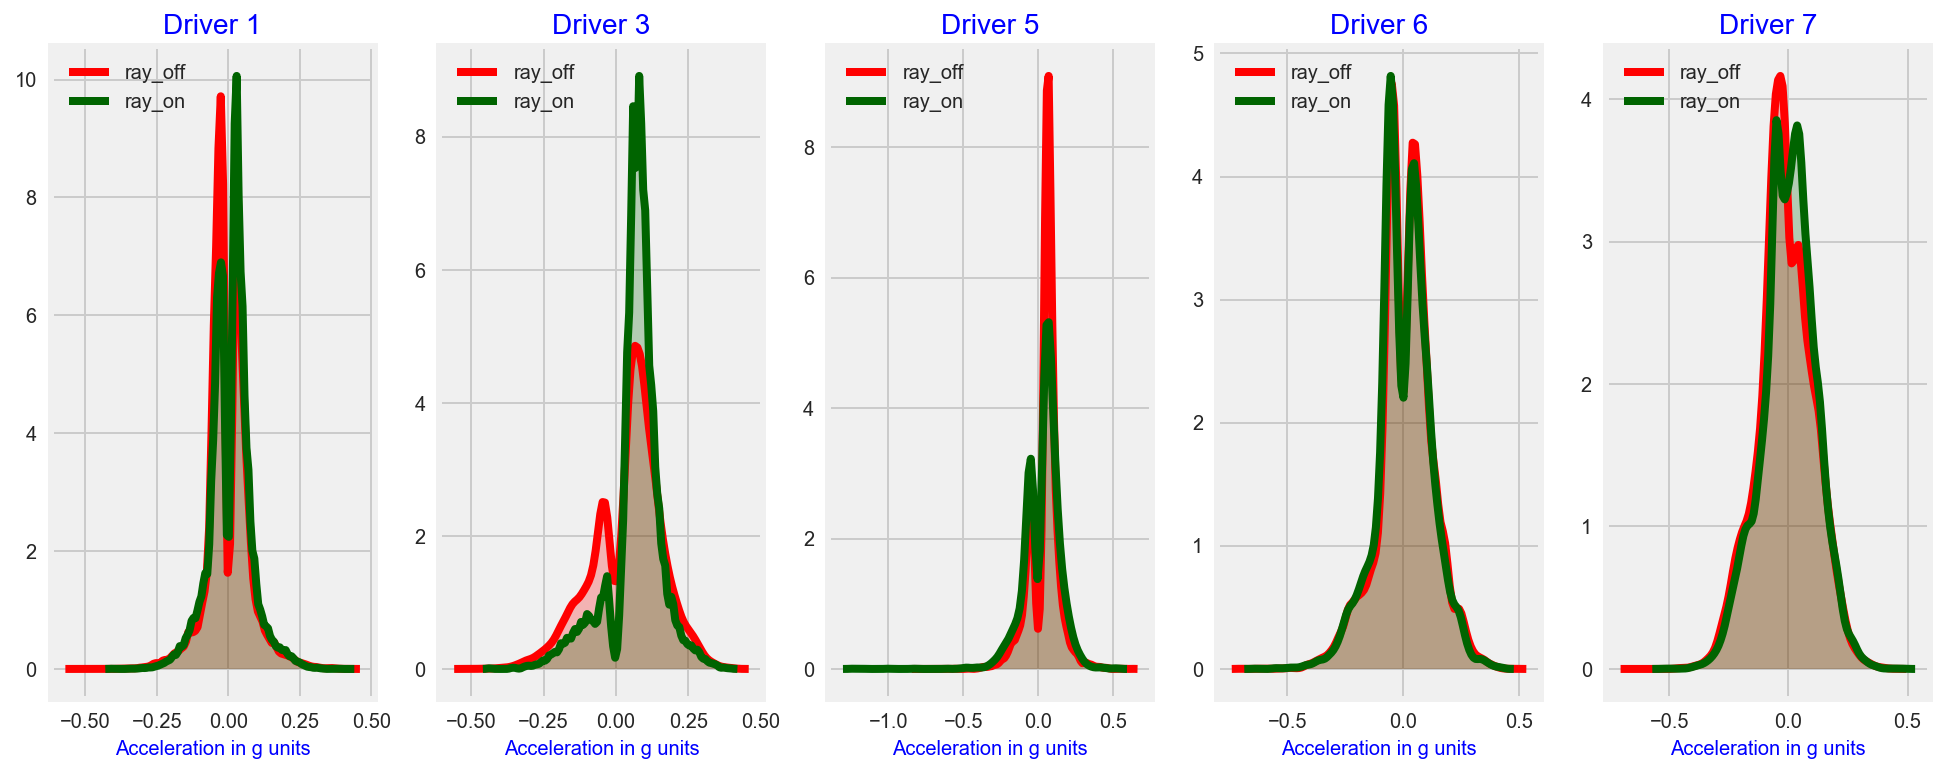

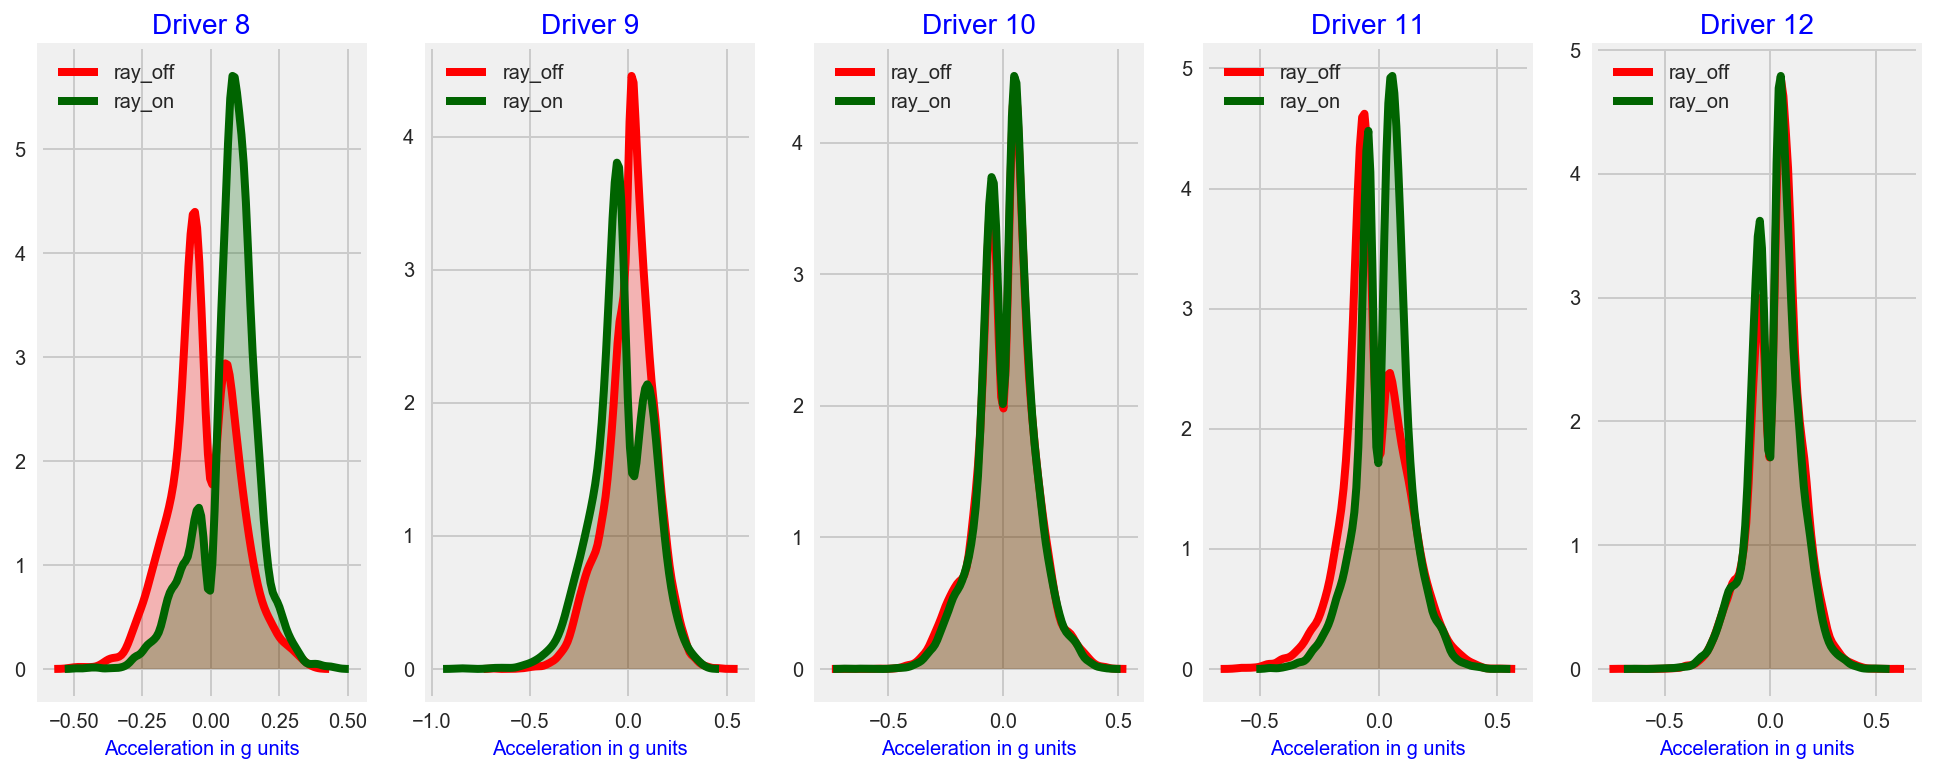

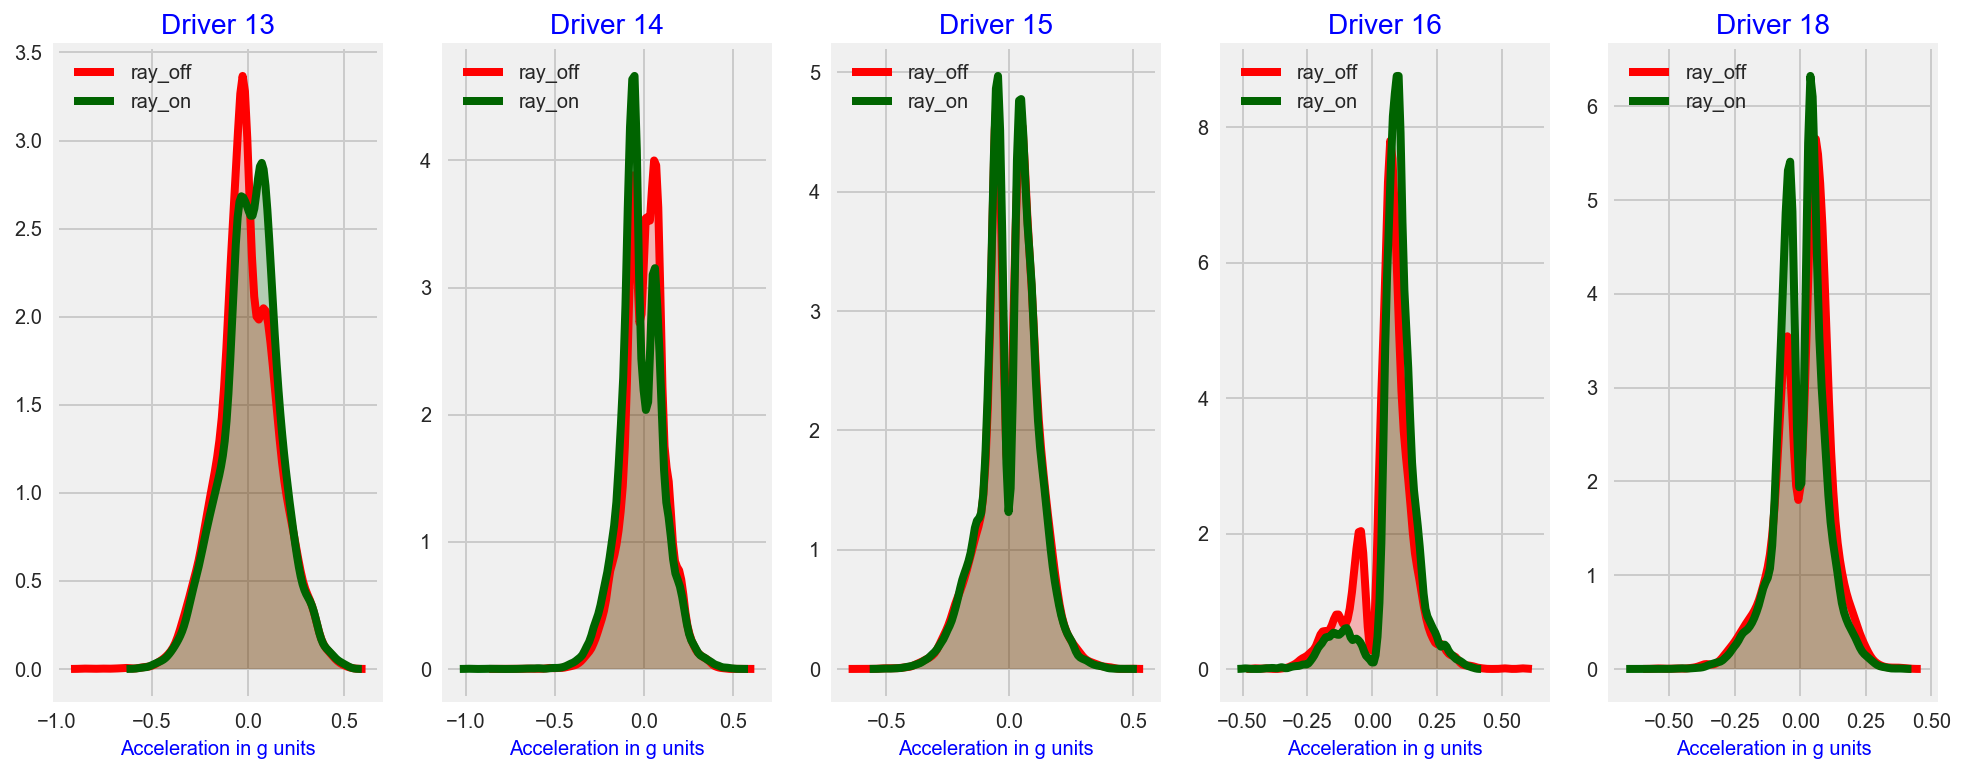

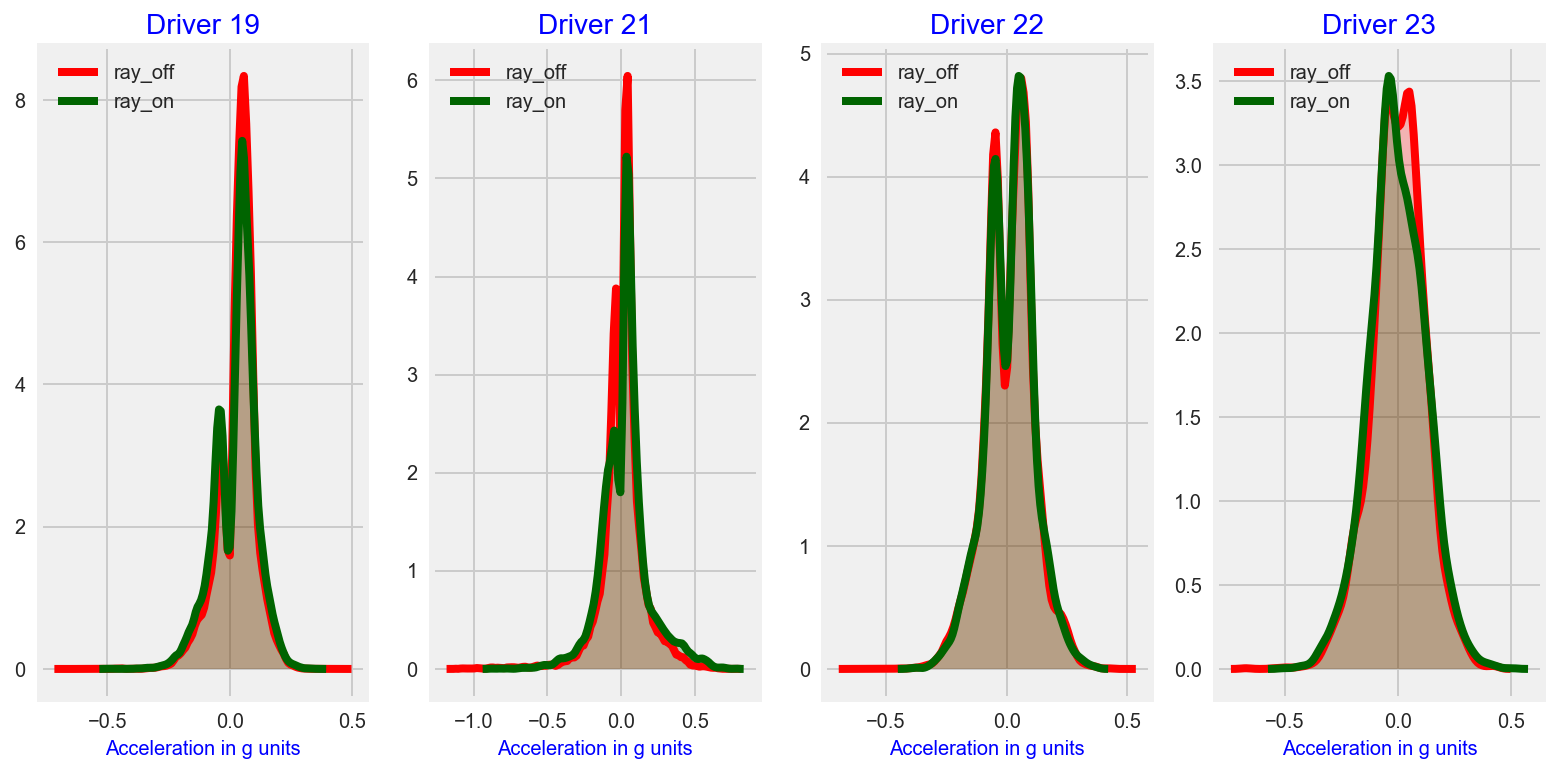

In [79]:
plot_multi_xaxis(['ray_off', 'ray_on'], '1','3','5','6','7')
plot_multi_xaxis(['ray_off', 'ray_on'], '8','9','10','11','12')
plot_multi_xaxis(['ray_off', 'ray_on'], '13','14','15','16','18')
plot_multi_xaxis(['ray_off', 'ray_on'], '19','21','22','23')

#### <span style='color:midnightblue'> Once again, there are some marked differences between individuals. </span>

#### <span style='color:midnightblue'> I'll also plot the distributions of the speed, rpm and distance for all drivers. </span>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



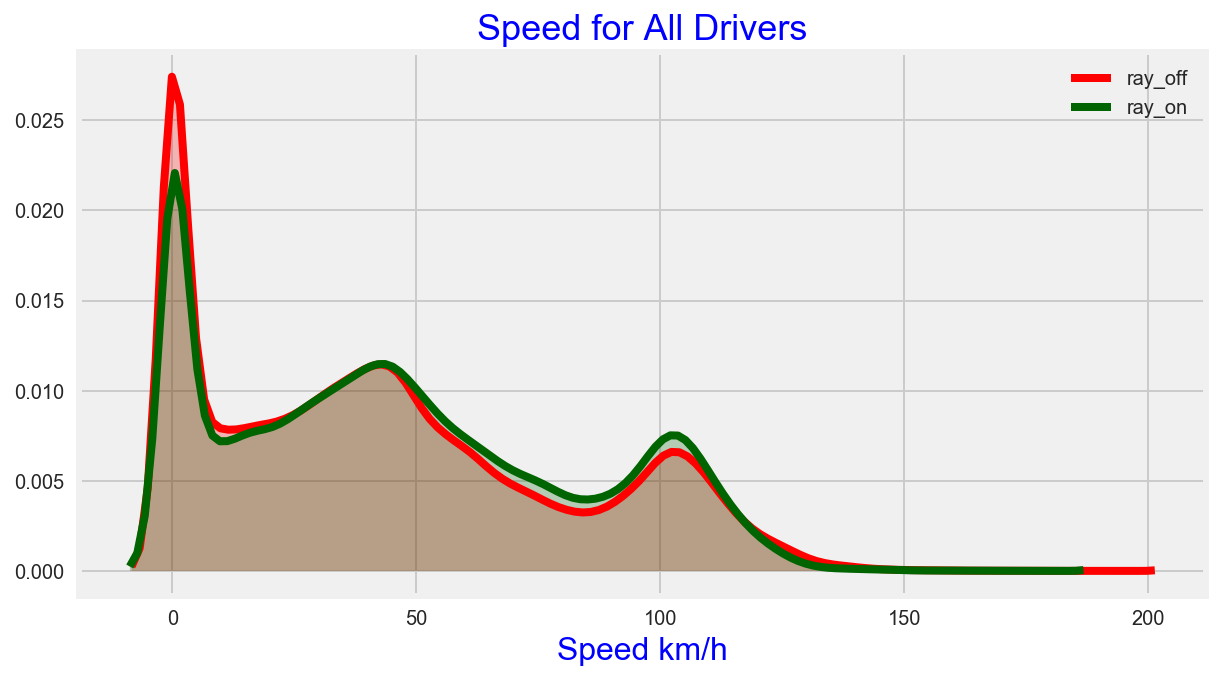

In [82]:
fig, ax = plt.subplots(figsize=(9,5))
for i, bn in enumerate(['ray_off', 'ray_on']):
    colors=['red', 'darkgreen']
    ax = sns.distplot(drive[drive.ray_connected == i].speed, hist=False, kde=True, color=colors[i], 
                      kde_kws={'shade':True}, label=bn)
ax.legend(loc='upper right')
plt.title('Speed for All Drivers', size=18, color='blue')
ax.set_xlabel("Speed km/h", size=16, color='blue')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



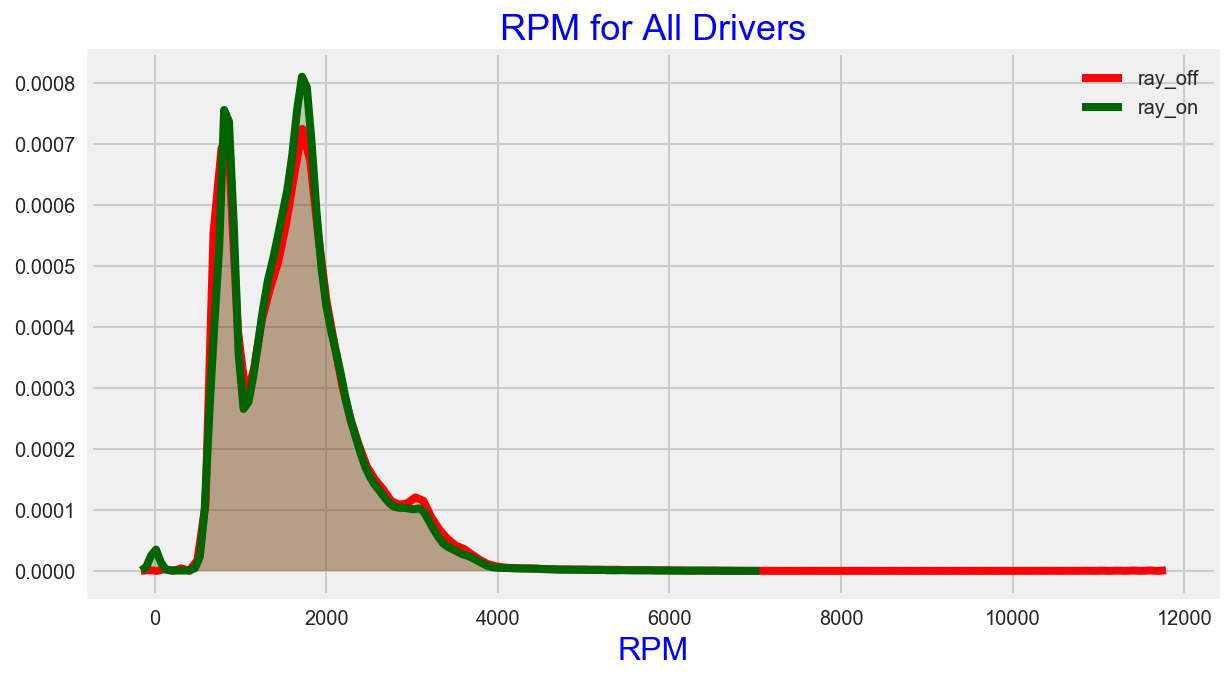

In [83]:
fig, ax = plt.subplots(figsize=(9,5))
for i, bn in enumerate(['ray_off', 'ray_on']):
    colors=['red', 'darkgreen']
    ax = sns.distplot(drive[drive.ray_connected == i].rpm, hist=False, kde=True, color=colors[i], 
                      kde_kws={'shade':True}, label=bn)
ax.legend(loc='upper right')
plt.title('RPM for All Drivers', size=18,color='blue')
ax.set_xlabel("RPM", size=16, color='blue')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



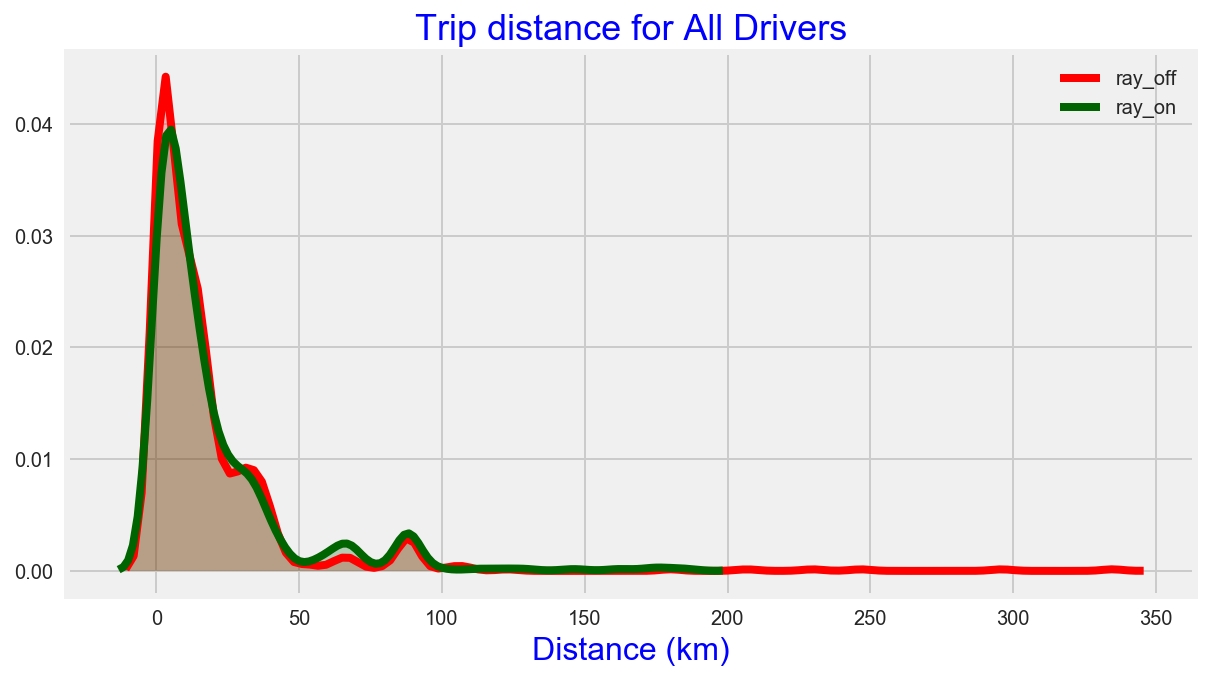

In [86]:
fig, ax = plt.subplots(figsize=(9,5))
for i, bn in enumerate(['ray_off', 'ray_on']):
    colors=['red', 'darkgreen']
    ax = sns.distplot(summ_trip[summ_trip.ray_on == i].trip_dist, hist=False, kde=True, color=colors[i], 
                      kde_kws={'shade':True}, label=bn)
ax.legend(loc='upper right')
plt.title('Trip distance for All Drivers', size=18, color='blue')
ax.set_xlabel("Distance (km)", size=16, color='blue')
plt.show()

#### <span style='color:midnightblue'> There are some slight differences in the distributions, but nothing that really stands out at this point. </span>

#### <span style='color:midnightblue'> To conclude the exploration and visualisation of the data, before I start some detailed analysis, I'll draw a pair plot. </span> 

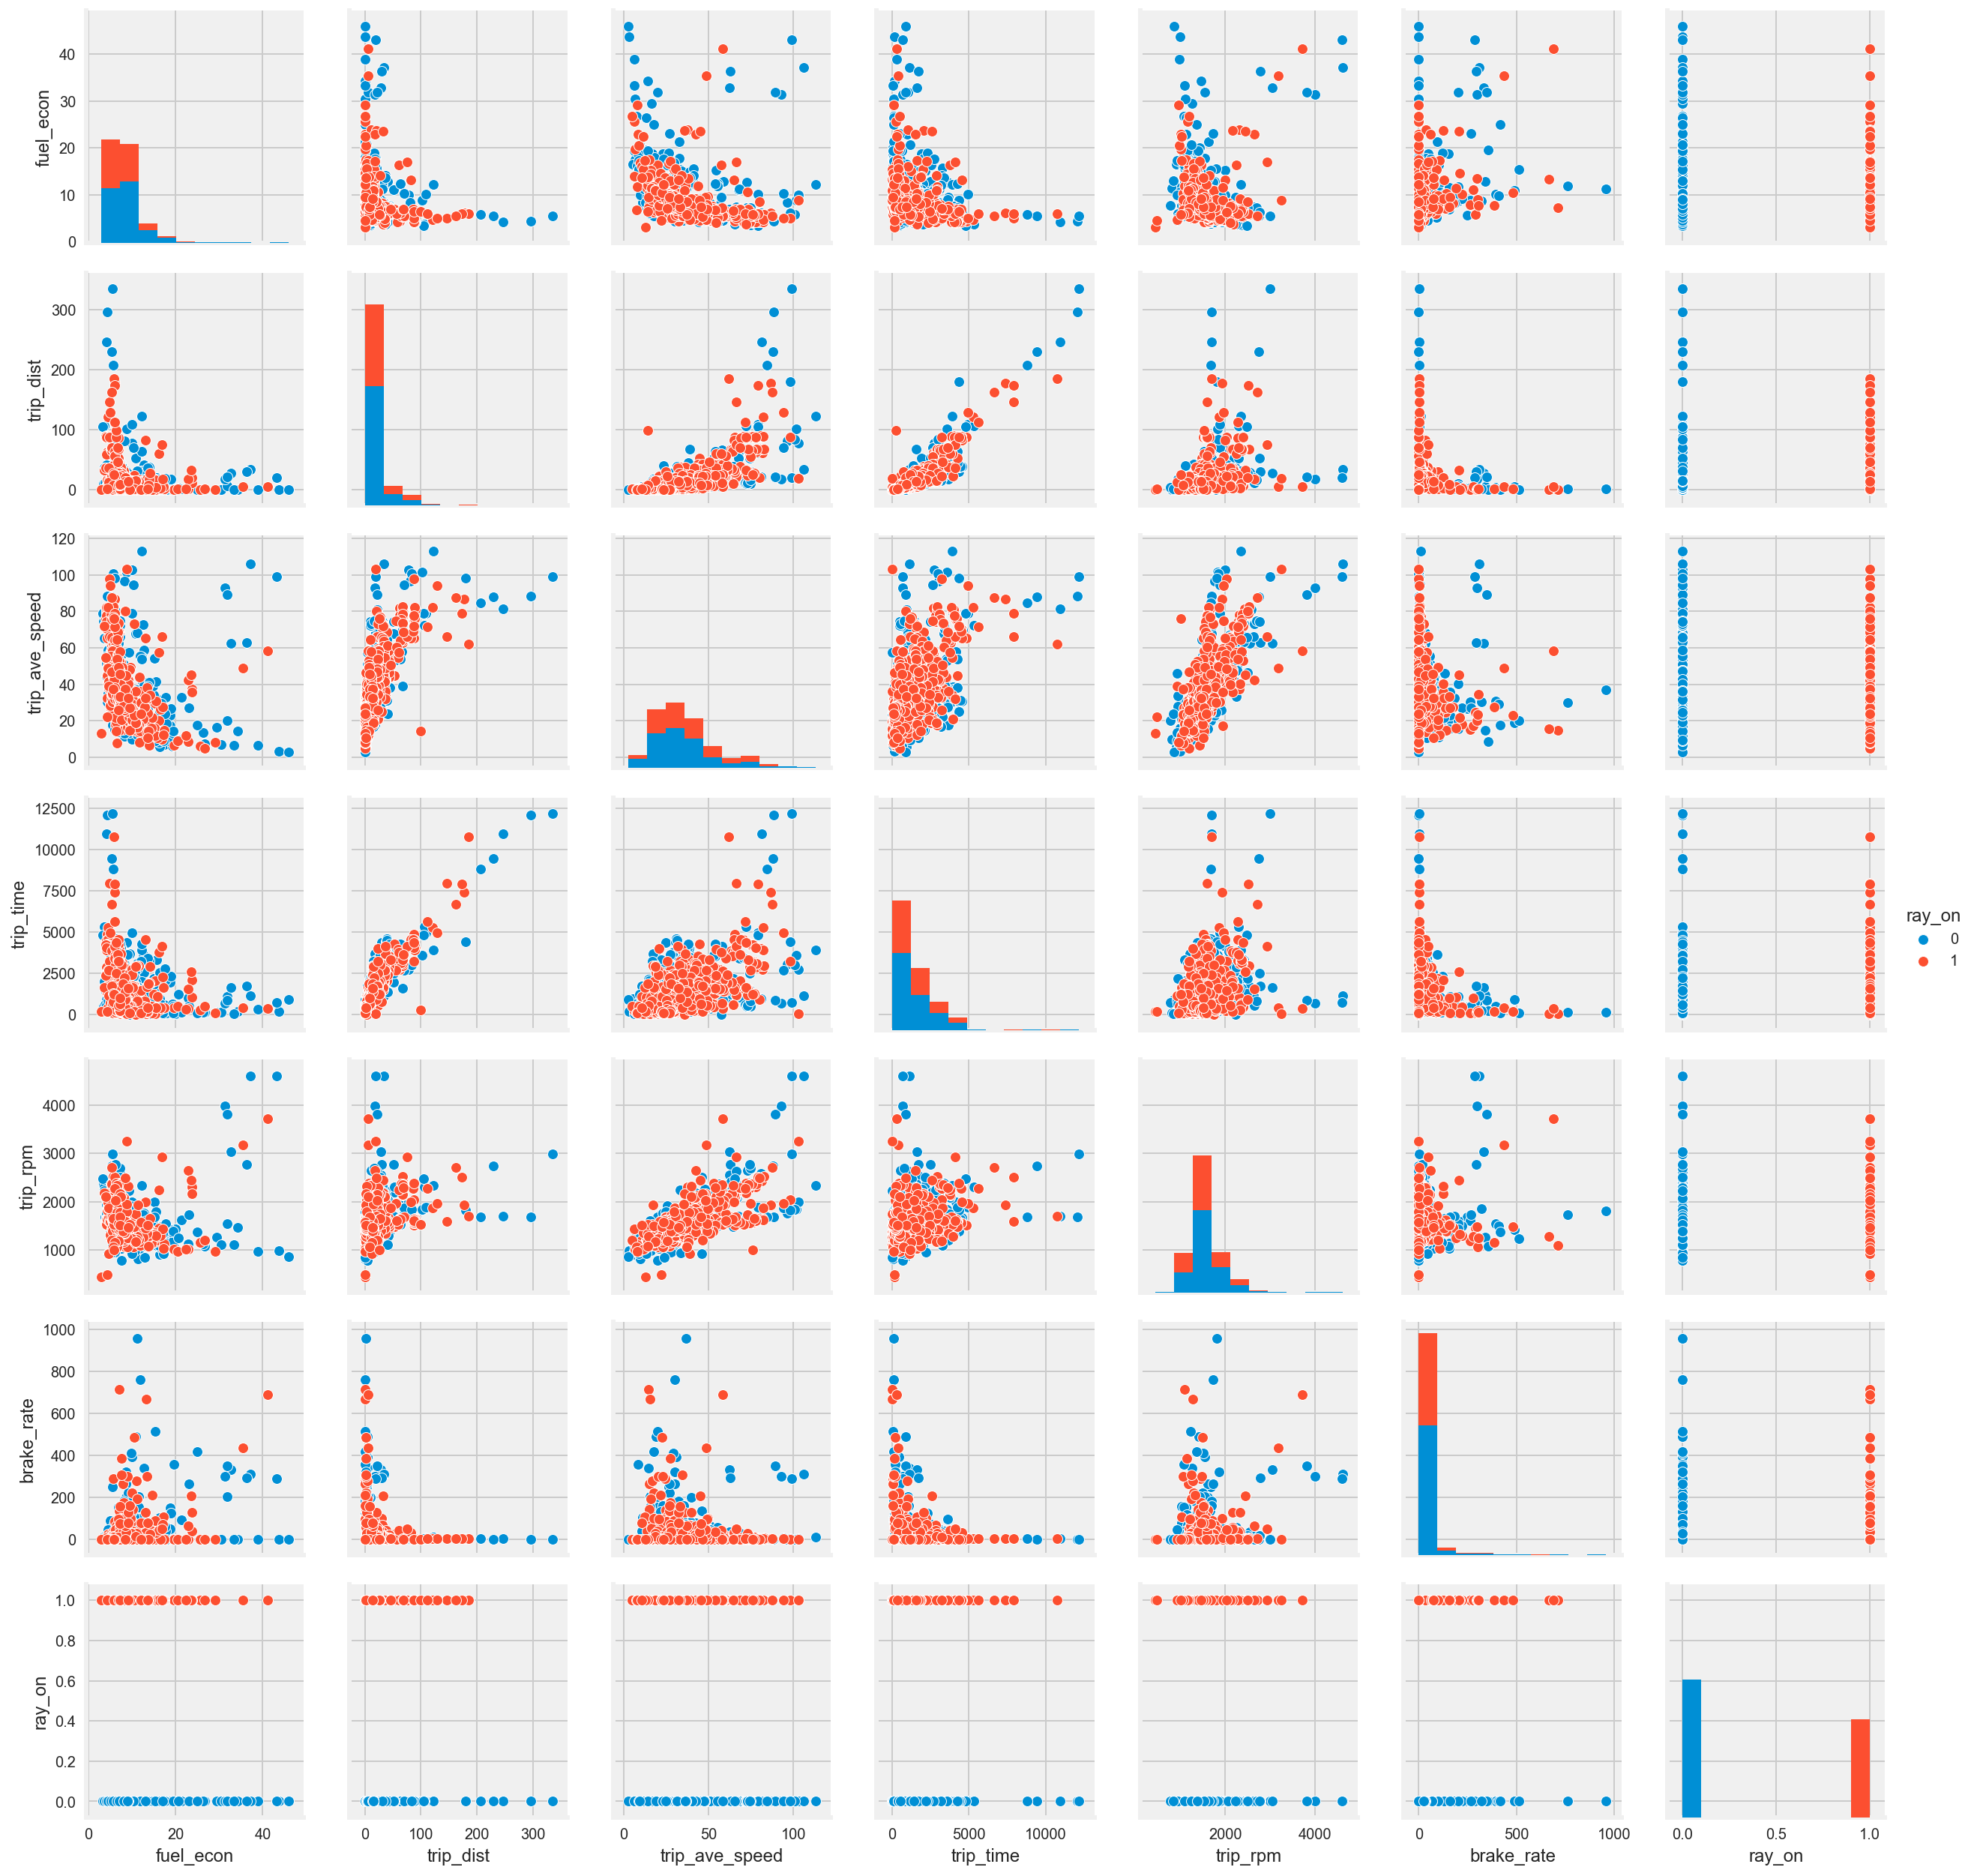

In [68]:
sns.pairplot(summ_trip[['fuel_econ','trip_dist','trip_ave_speed','trip_time','trip_rpm','brake_rate',
                        'ray_on']], hue='ray_on')

#### <span style='color:midnightblue'> One plot is interesting, and could be another sign of outliers, as mentioned with the individual fuel economy distribution plots above. At low trip distances, there is a much wider range of fuel economies than for longer trips. I will revisit this at some stage during the statistical analysis to follow. </span>

#### <span style='color:midnightblue'> This notebook has already become quite large. I'll start a new one for the statistical analysis and modelling of the data. </span>

##### <span style='color:darkgreen'> Notebook 2 can be found here: </span>
https://git.generalassemb.ly/DSI-SYD-2/capstone_greg/blob/master/part-04/capstone_greg_analysis_discussion.ipynb